In [278]:
import os
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

import numpy as np
import pickle
import glob
import json
from json import JSONDecodeError
import requests
import csv
from collections import Counter,defaultdict
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import scipy.stats as stats

Migrate results to [spreadsheet here](https://docs.google.com/spreadsheets/u/1/d/1_Ewrnb9gPkMfJaXhM71RAg7V8NhggU4OkJ5Q_ZctW-c/edit#gid=1747817466). Annotated spreadsheet with qualitative observations is [here](https://docs.google.com/spreadsheets/d/1wspavttD7o6e3UdreYwb-Bd5wd7eMM4bAPlxEztHLaY/edit#gid=0).

# Load data

In [2]:
reddit_dir = 'reddit_data'

In [3]:
posts_df = pd.read_pickle(os.path.join(reddit_dir,'posts_with_words.pkl'))
posts_df.shape

(911496, 21)

In [10]:
# comments_df = pd.read_pickle(os.path.join(reddit_dir,'comments_complete.pkl'))
# comments_df.shape

(7991395, 10)

In [4]:
background_posts_df = pd.read_pickle(os.path.join(reddit_dir,'background_corpus_posts_with_words_lemmatized.pkl'))
background_posts_df.shape

(6082915, 18)

Add background corpus posts from more years:

In [4]:
# background_posts_df = pd.read_pickle(os.path.join(reddit_dir,'background_corpus_posts_with_words.pkl'))
# print('Background posts df shape:',background_posts_df.shape)

# # Dedup from posts_df to avoid duplicate processing; can merge back later
# posts_df_post_indices = set(posts_df['id'])
# print('Size of posts_df:',len(posts_df_post_indices)) # Should be 975,950
# background_posts_df = background_posts_df.loc[~background_posts_df['id'].isin(posts_df_post_indices)]
# print('Disjoint background posts df shape:',background_posts_df.shape) # should be original shape - 975,950
# del posts_df_post_indices

Background posts df shape: (6814407, 16)
Size of posts_df: 911496
Disjoint background posts df shape: (6796250, 16)


Exclude posts/comments from bot users:

In [5]:
bots = pickle.load(open('bots.pkl','rb'))
top_commenters = pickle.load(open('top_commenters.pkl','rb'))
print(len(bots),len(top_commenters))
auths_to_exclude = set(bots) | set(top_commenters.index)

2805 100


In [15]:
posts_df = posts_df.loc[~posts_df.author.isin(auths_to_exclude)]
background_posts_df = background_posts_df.loc[~background_posts_df.author.isin(auths_to_exclude)]
#comments_df = comments_df.loc[~comments_df.author.isin(auths_to_exclude)]
posts_df.reset_index(drop=True,inplace=True)
background_posts_df.reset_index(drop=True,inplace=True)
print(len(posts_df),len(background_posts_df))

869922 6077070


In [64]:
del bots
del top_commenters
del auths_to_exclude

Older code for finding users that have contributed extremely high #comments (likely to be bots):

In [11]:
comments_per_auth = comments_df.groupby('author')
del comments_df
#posts_per_auth = posts_df.groupby("author")
#background_posts_per_auth = background_posts_df.groupby("author")
#del comments_per_auth

In [230]:
#sns.distplot([np.log(x) for x in list(comments_per_auth.size())])

In [12]:
top_commenters = comments_per_auth.size().sort_values()[-100:]
pickle.dump(top_commenters,open('top_commenters.pkl','wb'))
#sns.distplot([np.log(x) for x in list(top_commenters)])

In [18]:
#top_posters = posts_per_auth.size().sort_values()[-50:]
#sns.distplot([np.log(x) for x in list(top_posters)])

Posts linked to comments and comment text:

In [242]:
comment_ids_per_post = pd.read_csv('reddit_data/comment_ids_per_post.tsv',sep='\t',header=0)
post2comment_ids = dict(zip(comment_ids_per_post['post_id'],
                           comment_ids_per_post['comment_ids']))
post2comment_ids = {key: post2comment_ids[key].split(',') if isinstance(post2comment_ids[key],str) else []
                    for key in post2comment_ids}
post2comment_ids = {key: [x[3:] for x in post2comment_ids[key]] for key in post2comment_ids}
post2comment_ids['anbg0']

['c0ignhg', 'c0ignz0', 'c0igq3n']

In [239]:
comment_texts_df = pd.read_csv('reddit_data/text_per_comment.tsv',sep='\t',header=0)
comment_texts_df = comment_texts_df.loc[~pd.isnull(comment_texts_df.text)]
print(comment_texts_df.shape)
print(comment_texts_df.head())

(143274, 2)
  comment_id                                               text
0    d7fdpm4  That's fair. Thank you for having the courtesy...
1    d5cxylp  I simply don't understand what possible gains ...
2    d1ye1su  Seriously, how will this work lol.. By far the...
3    d5cmel8  Wasn't she conservative before meeting Bill? S...
4    d0rehcr           Are his private jets solar powered, too?


Export data for other applications:

In [205]:
posts_with_comments = posts_df.loc[posts_df.num_comments > 0]
posts_with_comments.id.to_pickle('posts_with_comments_ids.pkl')

Load annotated subreddit info:

In [188]:
annotated_subs = pd.read_csv('most_common_subreddits.tsv',sep='\t',header=0)

Curated subreddits:

In [ ]:
niche_subs = set(['mechmarket','PlantedTank','bicycling','Aquariums','microgrowery','Homebrewing',
             'vegan','cycling','chemistry','carporn','TalkativePeople','thinkpad','mechmarket','spacex','space',
                 'Futurology','bikewrench','airsoftmarket','airsoft'])
# 'Futurology'

non_niche_subs = set(['AskReddit','environment','politics','worldnews','climateskeptics',
                     'Showerthoughts','climate','askscience','The_Donald','science','EcoInternet',
                     'collapse','explainlikeimfive','conspiracy','NoStupidQuestions','australia',
                     'unpopularopinion','climatechange','news','energy','canada','Conservative',
                     'skeptic','todayilearned','shittyaskscience','ChapoTrapHouse','CanadaPolitics',
                     'EverythingScience','worldpolitics','europe','AskScienceDiscussion',
                     'ClimateOffensive','changemyview','ClimateActionPlan','AskTrumpSupporters',
                     'GlobalWarming','GlobalClimateChange','esist','Green'])

In [232]:
len(non_niche_subs)

39

# Define helper functions

In [8]:
"""Log-odds computations."""
from math import log, sqrt

def log_odds(c, n):
    """
    log_odds(c1, c2)
    Computes log odds for count data.
    Args:
      c: count of event.
      n: count of all events for the first sample.
    Returns:
      The log odds.
    """
    try:
        return log(c) - log(n - c) # log(c/(n-c)); log((c/n)/(1-c/n)) = log(c/(n-c))
    except ValueError:
        print(c, n)

def log_odds_ratio(c1, n1, c2, n2):
    """
    log_odds_ratio(c1, n1, c2, n2)
    Computes log odds for two counts.
    Args:
      c1: count of the event in the first sample.
      n1: count of all events for the first sample.
      c2: count in the event in the second sample.
      n1: count of all events for the second sample.
    Returns:
      Log odds.
    """
    try:
        return log_odds(c1, n1) - log_odds(c2, n2)
    except ValueError:
        print(c1, n1, c2, n2)
        
def log_odds_ratio_idp(c1, n1, c2, n2, c3, n3):
    """
    log_odds_ratio_idp(c1, n1, c2, n2, c3, n3)
    Computes log odds ratio with an informative Dirichlet prior, as in:
        Monroe, B. L., Colaresi, M. P. and Quinn, K. M. 2009. Fightin' words:
        Lexical feature selection and evaluation for identifying the content of
        political conflict. Political Analysis 16: 372-403.
    Args:
      c1: count of the event (a word occurring) in group 1 (high eng.).
      n1: count of all events (all words) for group 1 (high eng.).
      c2: count of the event (a word occurring) in group 2 (e.g. low eng.).
      n2: count of all events (all words) in group 2 (e.g. low eng.).
      n3: count of all events (all words) in the third (i.e., the prior) sample (background corpus).
    Returns:
      Weighted log odds.
    """
    c1p = c1 + c3
    c2p = c2 + c3
    numerator = log(c1p / (n1 + n3)) - log(c2p / (n2 + n3))
    sigma = sqrt(1. / c1p + 1. / c2p)
    return numerator / sigma

In [343]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def boxplot_sorted(df, by, column, rotation=90):
    df2 = pd.DataFrame({col:vals[column] for col, vals in df.groupby(by)})
    meds = df2.median().sort_values()
    fig,ax = plt.subplots(figsize=(14,10))
    sns.boxplot(data=df,x=by,y=column,order=meds.index)
    ax.set_xlabel("")
    ax.set_ylabel(column,fontsize=28)
    plt.xticks(rotation=rotation,fontsize=24)
    plt.show()

In [10]:
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('words')
WORDS = set(nltk.corpus.words.words())
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


def get_lemmas(x):
    
    if len(x) > 0:
        return json.dumps([lemmatizer.lemmatize(w.lower(), get_wordnet_pos(w.lower())) 
                       for w in nltk.word_tokenize(x)])
    return None

[nltk_data] Downloading package words to /sailhome/yiweil/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [131]:
len(WORDS)

235892

In [223]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
#print(stopwords.words('english'))
STOPWORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /sailhome/yiweil/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Get lemmas within posts/comments

In [11]:
posts_df['title_lemmas'] = posts_df['title_lemmas'].apply(lambda x: json.loads(x))
posts_df['body_lemmas'] = posts_df['body_lemmas'].apply(lambda x: json.loads(x) if x is not None else [])
background_posts_df['title_lemmas'] = background_posts_df['title_lemmas'].apply(lambda x: json.loads(x))
background_posts_df['body_lemmas'] = background_posts_df['body_lemmas'].apply(lambda x: json.loads(x)
                                                                             if x is not None else [])

In [72]:
posts_df['title_lemmas'] = posts_df.title.apply(get_lemmas)
posts_df['body_lemmas'] = posts_df.text.apply(get_lemmas)
#posts_df.to_pickle(os.path.join(reddit_dir,'posts_with_words.pkl'))

In [13]:
background_posts_df['title_lemmas'] = background_posts_df.title.apply(get_lemmas)
background_posts_df['body_lemmas'] = background_posts_df.text.apply(get_lemmas)
#background_posts_df.to_pickle(os.path.join(reddit_dir,'background_corpus_posts_with_words_lemmatized.pkl'))

In [ ]:
comment_texts_df['lemmas'] = comment_texts_df.text.apply(get_lemmas)

# General high frequency, non-stop words

In [226]:
# all_title_lemmas = [item for sublist in posts_df['title_lemmas'] for item in sublist
#                    if item not in STOPWORDS]
# all_non_stop_title_lemmas_counted = Counter(all_title_lemmas)
all_body_lemmas = [item for sublist in posts_df['body_lemmas'] for item in sublist
                   if item not in STOPWORDS]
all_non_stop_body_lemmas_counted = Counter(all_body_lemmas)

In [228]:
#sorted(all_non_stop_body_lemmas_counted.items(),key=lambda x:x[1],reverse=True)

# General: LOR pair-wise b/w subs

In [ ]:
# GlobalWarming vs. climatechange

In [337]:
cc_ids = posts_df.loc[posts_df.subreddit=='GlobalWarming']['id']
skeptic_ids = posts_df.loc[posts_df.subreddit=='climatechange']['id']
print(len(cc_ids),len(skeptic_ids))

1675 5996


In [342]:
# cc_vs_skeptics_lor_df = lor_report(posts_df,VOCAB_COUNTS_BACKGROUND_TITLE+VOCAB_COUNTS_BACKGROUND_BODY,
#            N_BACKGROUND_TITLE_LEMS+N_BACKGROUND_BODY_LEMS,
#            set(cc_ids),set(skeptic_ids),'title_lemmas','climate_vs_climateskeptics.png',n_to_label=40)

In [341]:
#cc_vs_skeptics_lor_df.sort_values('lor_hi_to_lo',ascending=False)[-50:]

# High vs. low engagement posts

In [ ]:
posts_df['log_num_comments'] = posts_df['num_comments'].apply(lambda x: np.log(x+0.001))
posts_df['log_score'] = posts_df['score'].apply(lambda x: np.log(x+0.001))

Relationship b/w log_num_comments and log_score:

In [286]:
# fig,ax=plt.subplots(figsize=(10,10))
# sns.lmplot(x='log_score',y='log_num_comments',data=posts_df.loc[(posts_df['log_score'] >= 0) &
#                                                                 (posts_df['log_num_comments'] >= 0)])
# ax.set_xlabel("Score",fontsize=24)
# ax.set_ylabel("Num. Comments",fontsize=24)

In [279]:
stats.pearsonr(posts_df['score'],posts_df['num_comments'])

(0.6783352377172486, 0.0)

In [280]:
stats.pearsonr(posts_df['log_score'],posts_df['log_num_comments'])

(0.2122565469681208, 0.0)

## Thresholding

Need to set bounds for long and short comment-thread posts. First visualize distribution:

Text(0.5, 0, 'Log num. comments')

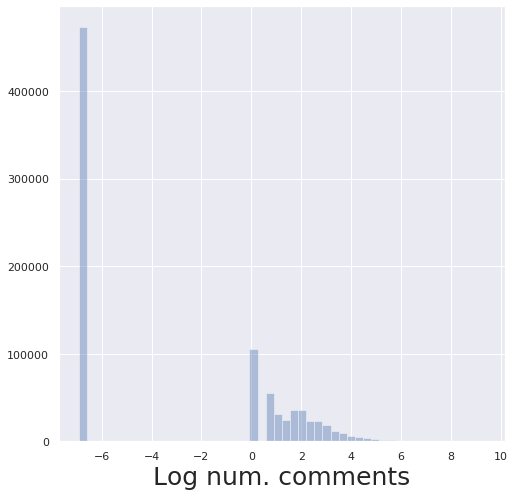

In [287]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(posts_df['log_num_comments'],
                 kde=False, ax=ax)
ax.set_xlabel('Log num. comments',fontsize=25)

In [32]:
mean_log_num_comments = posts_df['log_num_comments'].mean()
std_log_num_comments = posts_df['log_num_comments'].std()
posts_df['log_num_comments'].mean(),posts_df['log_num_comments'].std()

(-3.069087737860533, 4.290871222305884)

In [233]:
# %matplotlib inline
# fig, ax = plt.subplots(figsize=(8, 8))
# sns.distplot(posts_df['log_score'],
#                  kde=False, ax=ax)
# ax.set_xlabel('Log score',fontsize=25)

In [50]:
mean_log_score = posts_df['log_score'].mean()
std_log_score = posts_df['log_score'].std()
mean_log_score,std_log_score

(0.339525161066467, 2.3387329265425474)

In [291]:
mean_log_score-0.5*std_log_score,mean_log_score+0.5*std_log_score

(-0.8032955526622982, 1.5557038348624121)

In [214]:
def partition_lo_hi_posts_absolute(posts_,metric_,lo_thresh,hi_thresh,exclusion_factor_=0):
    """
    param exclusion_factor_: The float proportion of posts in the middle to exclude. 
    By default this factor is 0, meaning that posts below the low threshold are low engagement and 
    above the high threshold are high engagement, even if the thresholds are very close together.
    """
    
    sorted_posts_ = posts_.sort_values(metric_,ascending=True)
    
    print('Partitioning {} posts according to {} as engagement metric...'.format(len(posts_),metric_))
    lo_ids = list(sorted_posts_.loc[sorted_posts_[metric_] <= lo_thresh]['id'])
    hi_ids = list(sorted_posts_.loc[sorted_posts_[metric_] >= hi_thresh]['id'])
    
    print('Excluding middle {}...'.format(exclusion_factor_))
    lo_ids = lo_ids[:int((1-exclusion_factor_)*len(lo_ids)+0.5)] # exclude final fraction
    hi_ids = hi_ids[int(exclusion_factor_*len(hi_ids)+0.5):]    # exclude first fraction
    
    print('Number of low engagement posts:',len(lo_ids))
    print('Number of high engagement posts:',len(hi_ids))
    
    return {'lo':lo_ids,'hi':hi_ids}


def partition_lo_hi_posts_relative(posts_,metric_,std_factor_=0):
    """
    param std_factor_: The int number of standard deviations above and below the mean at which to define the 
    high and low thresholds for partitioning engagement. By default this factor is 0, meaning that posts with
    engagement above the mean are high engagement and posts below the mean are low engagement.
    """
    
    lo_ids, hi_ids = [], []
    posts_by_sub_ = posts_.groupby('subreddit')
    subs_ = posts_by_sub_.first().index
    print('Partitioning {} posts in {} subreddits according to {} as engagement metric...'.format(
        len(posts_),len(subs_),metric_))
    
    for sub_ in subs_:
        sub_posts = posts_by_sub_.get_group(sub_)
        
        sub_mean = sub_posts[metric_].mean()
        sub_std = sub_posts[metric_].std() if len(sub_posts) > 1 else 0
        lo_thresh = sub_mean-std_factor_*sub_std
        hi_thresh = sub_mean+std_factor_*sub_std
        if lo_thresh == hi_thresh:
            hi_thresh += 0.001 # adjust so that partitions are disjoint
            
#         print('subreddit:',sub_)
#         print('mean:',sub_mean)
#         print('std:',sub_std)
#         print('lo, high thresholds:',lo_thresh,hi_thresh)
        
        sorted_posts_ = sub_posts.sort_values(metric_,ascending=True)
        sorted_posts_.reset_index(drop=True,inplace=True)
        left_partition_stop = sorted_posts_[metric_].searchsorted(lo_thresh,
                                                            side='right') # the index of last row < LO 
        right_partition_start = sorted_posts_[metric_].searchsorted(hi_thresh,
                                                            side='left')+1 # the index of first row > HI 
    
        sub_lo_ids = sorted_posts_[:left_partition_stop] 
        sub_hi_ids = sorted_posts_[right_partition_start+1:]
        lo_ids.extend(list(sub_lo_ids['id']))
        hi_ids.extend(list(sub_hi_ids['id']))
        
#         print('left stop point:',left_partition_stop)
#         print('right start point:',right_partition_start)
#         print(sorted_posts_[left_partition_stop-3:left_partition_stop])
#         print(sorted_posts_[right_partition_start+1:right_partition_start+4])
    
    print('Number of low engagement posts:',len(lo_ids))
    print('Number of high engagement posts:',len(hi_ids))
    
    return {'lo':lo_ids,'hi':hi_ids}

## Engagement broken down by subreddit

In [96]:
posts_by_sub = posts_df.groupby('subreddit')
posts_by_sub.size().sort_values(ascending=False)

subreddit
EcoInternet            54278
TalkativePeople        45244
environment            34480
AutoNewspaper          21686
AskReddit              20107
                       ...  
installation01             1
instantworldnews           1
instructables              1
instructionaldesign        1
00s                        1
Length: 30796, dtype: int64

In [111]:
mean_engagement_per_sub = {'log_num_comments': {sub: posts_by_sub.get_group(sub)['log_num_comments'].mean()
                     for sub in posts_by_sub.first().index},
                     'log_score': {sub: posts_by_sub.get_group(sub)['log_score'].mean()
                     for sub in posts_by_sub.first().index}}

In [112]:
top_30_subs = set(posts_by_sub.size().sort_values(ascending=False).index[:30])
top_30_comment_subs = sorted(mean_engagement_per_sub['log_num_comments'].items(),key=lambda x: x[1],reverse=True)
top_30_score_subs = sorted(mean_engagement_per_sub['log_score'].items(),key=lambda x: x[1],reverse=True)

In [121]:
# pd.DataFrame({'log(#comments)':[x[0] for x in top_30_comment_subs],
#               'log(score)':[x[0] for x in top_30_score_subs]})

In [104]:
top_30_posts_df = posts_df.loc[posts_df.subreddit.isin(top_30_subs)]

In [131]:
#boxplot_sorted(top_30_posts_df, 'subreddit', 'log_num_comments')

In [130]:
#boxplot_sorted(top_30_posts_df, 'subreddit', 'log_score', rotation=70)

## Which subs do high vs. low engagement posts belong to?

In [366]:
# absolute engagement; 0 vs. non-zero #comments
hi_eng_df = posts_df.iloc[partition['hi']]
lo_eng_df = posts_df.iloc[partition['lo']]

In [68]:
#del hi_eng_df
#del lo_eng_df

In [45]:
# absolute engagement; +/0 0.5 std.'s above global mean
LO_THRESH = mean_log_num_comments-0.5*std_log_num_comments
HI_THRESH = mean_log_num_comments+0.5*std_log_num_comments
partition = partition_lo_hi_posts_absolute(posts_df,'log_num_comments',LO_THRESH,HI_THRESH)#,exclusion_factor_=0.2)

Partitioning 869922 posts according to log_num_comments as engagement metric...
Excluding middle 0...
Number of low engagement posts: 473050
Number of high engagement posts: 396872


In [63]:
# per-sub defined engagement; +/- 1 std.'s from mean
partition_rel = partition_lo_hi_posts_relative(posts_df,'log_num_comments',std_factor_=1)

Partitioning 869922 posts in 30796 subreddits according to log_num_comments as engagement metric...
Number of low engagement posts: 139194
Number of high engagement posts: 83256


In [71]:
#del partition_rel
#del partition_rel_2

In [93]:
# per-sub defined engagement; +/- 0.5 std.'s from mean
partition_rel_2 = partition_lo_hi_posts_relative(posts_df,'log_num_comments',std_factor_=0.5)

Partitioning 869922 posts in 30796 subreddits according to log_num_comments as engagement metric...
Number of low engagement posts: 227962
Number of high engagement posts: 220715


Plot proportion of posts that are hi vs. lo engagement, broken down by sub:

In [95]:
hi_eng_ids = set(partition_rel['hi'])
hi_eng_ids_2 = set(partition_rel_2['hi'])
lo_eng_ids = set(partition_rel['lo'])
lo_eng_ids_2 = set(partition_rel_2['lo'])

In [101]:
# Plot proportion of posts that are hi vs. lo engagement, broken down by sub
HI_SET = hi_eng_ids
LO_SET = lo_eng_ids
posts_df['engagement'] = posts_df['id'].apply(lambda x: 'high' if x in HI_SET else 
                                              ('low' if x in LO_SET else 'neither'))

In [102]:
most_common_subs_30 = posts_df.subreddit.value_counts().index[:30]
sub_groups = posts_df.groupby('subreddit')
most_common_nonzero_subs_30 = posts_df.loc[posts_df.num_comments > 0].subreddit.value_counts().index[:30]
sub_groups_nonzero = posts_df.loc[posts_df.num_comments > 0].groupby('subreddit')
most_common_nonniche_subs_30 = posts_df.loc[~posts_df.subreddit.isin(niche_subs)].subreddit.value_counts().index[:30]
sub_groups_nonniche = posts_df.loc[~posts_df.subreddit.isin(niche_subs)].groupby('subreddit')
most_common_nonzero_nonniche_subs_30 = posts_df.loc[(posts_df.num_comments > 0) & 
                                                   (~posts_df.subreddit.isin(niche_subs))].subreddit.value_counts().index[:30]
sub_groups_nonzero_nonniche = posts_df.loc[(posts_df.num_comments > 0) &
                                          (~posts_df.subreddit.isin(niche_subs))].groupby('subreddit')

In [103]:
posts_df.engagement.value_counts()

neither    647472
low        139194
high        83256
Name: engagement, dtype: int64

In [104]:
subs_df_ = []
counts_df_ = []
engs_df_ = []

for sub in most_common_nonniche_subs_30:
    sub_df = sub_groups_nonniche.get_group(sub)
    sub_eng_counts = sub_df.engagement.value_counts()
    hi_count = sub_eng_counts['high'] if 'high' in sub_eng_counts else 0
    lo_count = sub_eng_counts['low'] if 'low' in sub_eng_counts else 0
    subs_df_.extend([sub,sub])
    counts_df_.extend([hi_count,lo_count])
    engs_df_.extend(['high','low'])
    
df_ = pd.DataFrame({"subreddit":subs_df_,
                   "post count":counts_df_,
                   "engagement":engs_df_})

In [235]:
# fig,ax = plt.subplots(figsize=(12,8))
# g = sns.barplot(x="subreddit",y="post count",data=df_.sort_values(['engagement','post count']),hue="engagement")
# ax.set_ylabel('Number of posts',fontsize=24)
# ax.set_xlabel('',fontsize=24)
# ax.set_xticklabels(g.get_xticklabels(),rotation=90,fontsize=20)
# ax.set_title("Low/High engagement = per-sub mean +/- 1*std, exclude posts from niche-interest subs",fontsize=28)

## LOR words in high vs. low engagement posts

Log odds analyses (by engagement, by stance)
1. Posts
    * A. separate title from body and analyze separately; then together
    * B. try different thresholds for partitioning into lo and hi engagement
    * C. exclude niche interest subreddits
    * D. engagement based on score rather than length
1. Above addresses what posts are about. But what are the comments in long vs. shorter threads talking about?
1. apply other potential categories to data comparisons (e.g. whether original post mentions climate change)

In [ ]:
BACKGROUND_TITLE_LEMS = [item for sublist in background_posts_df['title_lemmas'] for item in sublist]
BACKGROUND_BODY_LEMS = [item for sublist in background_posts_df['body_lemmas'] for item in sublist]
BACKGROUND_TITLE_LEMS = [x for x in BACKGROUND_TITLE_LEMS if x.isalpha()]
BACKGROUND_BODY_LEMS = [x for x in BACKGROUND_BODY_LEMS if x.isalpha()]
BACKGROUND_TITLE_LEMS = [x for x in BACKGROUND_TITLE_LEMS if x in WORDS]
BACKGROUND_BODY_LEMS = [x for x in BACKGROUND_BODY_LEMS if x in WORDS]
N_BACKGROUND_TITLE_LEMS = len(BACKGROUND_TITLE_LEMS)
N_BACKGROUND_BODY_LEMS = len(BACKGROUND_BODY_LEMS)

VOCAB_COUNTS_BACKGROUND_TITLE = Counter(BACKGROUND_TITLE_LEMS)
pickle.dump(VOCAB_COUNTS_BACKGROUND_TITLE,open('vocab_counts_background_corpus_title_lemmas.pkl','wb'))
#del BACKGROUND_TITLE_LEMS 
VOCAB_COUNTS_BACKGROUND_BODY = Counter(BACKGROUND_BODY_LEMS)
pickle.dump(VOCAB_COUNTS_BACKGROUND_BODY,open('vocab_counts_background_corpus_body_lemmas.pkl','wb'))
#del BACKGROUND_BODY_LEMS

In [332]:
print(N_BACKGROUND_TITLE_LEMS,N_BACKGROUND_BODY_LEMS)

59422439 56076171


In [75]:
# del BACKGROUND_TITLE_LEMS
# del BACKGROUND_BODY_LEMS

In [363]:
def lor_report(df_,background_vocab_counts,N_back,g1_indices,g2_indices,X_str,savename,n_to_label=40):
    
    # Get X for groups 1 and 2
    print('Partitioning data into groups')
    if len(g1_indices) < len(g2_indices):
        print('Subsampling from second group')
        min_ = len(g1_indices)
        g2_indices = np.random.choice(list(g2_indices), size=min_, replace=False)
    else:
        print('Subsampling from first group')
        min_ = len(g2_indices)
        g1_indices = np.random.choice(list(g1_indices), size=min_, replace=False)
    
    g1_posts = df_.loc[df_['id'].isin(g1_indices)]
    g2_posts = df_.loc[df_['id'].isin(g2_indices)] 
    
    if X_str == 'comments':
        # go from post to comment indices:
        g1_comm_ids = [post2comment_ids[p_id] for p_id in g1_posts['id']] # list of lists
        g1_comm_ids = [item for sublist in g1_comm_ids for item in sublist] # flat list
        
        g2_comm_ids = [post2comment_ids[p_id] for p_id in g2_posts['id']] # list of lists
        g2_comm_ids = [item for sublist in g2_comm_ids for item in sublist] # flat list
        
        # then go from comment indices to comment lemmas
        hi_eng_lems = [comment_id2lemmas[comm_id] for comm_id in g1_comm_ids
                         if comm_id in comment_id2lemmas] 
        lo_eng_lems = [comment_id2lemmas[comm_id] for comm_id in g2_comm_ids
                         if comm_id in comment_id2lemmas] 
    elif X_str == 'both':
        hi_eng_lems = [item for sublist in g1_posts['title_lemmas'] for item in sublist] + \
        [item for sublist in g1_posts['body_lemmas'] for item in sublist]
        lo_eng_lems = [item for sublist in g2_posts['title_lemmas'] for item in sublist] + \
        [item for sublist in g2_posts['body_lemmas'] for item in sublist]
    else:
        hi_eng_lems = [item for sublist in g1_posts[X_str] for item in sublist]
        lo_eng_lems = [item for sublist in g2_posts[X_str] for item in sublist]
    
    # Exclude non-alpha
    hi_eng_lems = [x for x in hi_eng_lems if x.isalpha()]
    lo_eng_lems = [x for x in lo_eng_lems if x.isalpha()]
    print("Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low):",
          len(hi_eng_lems),len(lo_eng_lems))
    N_hi, N_lo = len(hi_eng_lems), len(lo_eng_lems)
    
    # Exclude non-nltk words
    hi_eng_lems = [x for x in hi_eng_lems if x in WORDS and x not in STOPWORDS]
    lo_eng_lems = [x for x in lo_eng_lems if x in WORDS and x not in STOPWORDS]
    print("Excluding non-nltk words. Number of tokens in 2 post groups (high, low):",
          len(hi_eng_lems),len(lo_eng_lems))
    N_hi, N_lo = len(hi_eng_lems), len(lo_eng_lems)
    N_back += N_hi
    N_back += N_lo
    
    hi_eng_vocab = set(hi_eng_lems)
    lo_eng_vocab = set(lo_eng_lems)
    print("Vocab size of hi, lo engagement, background posts:",
          len(hi_eng_vocab),len(lo_eng_vocab),len(background_vocab_counts))
    
    joint_vocab = hi_eng_vocab.intersection(lo_eng_vocab)
    print('Size of joint vocab:',len(joint_vocab))
    print('Proportion of joint vocab in hi:',len(joint_vocab)/len(hi_eng_vocab))
    print('Proportion of joint vocab in lo:',len(joint_vocab)/len(lo_eng_vocab))
    
    vocab_counts_hi = Counter(hi_eng_lems)
    vocab_counts_lo = Counter(lo_eng_lems)
    background_vocab_counts += vocab_counts_hi
    background_vocab_counts += vocab_counts_lo       
    L_O_R_dict = {w: log_odds_ratio_idp(vocab_counts_hi[w],N_hi,vocab_counts_lo[w],N_lo,
                                        background_vocab_counts[w],N_back)
             for w in joint_vocab}
    
    # Plot LOR[w] against its frequency (sum over counts in hi and lo corpora)
    lor_df = pd.DataFrame(L_O_R_dict.items())
    lor_df.columns = ['word','lor_hi_to_lo']
    lor_df['freq'] = [vocab_counts_hi[w]+vocab_counts_lo[w] for w in lor_df['word']]
    lor_df['log_freq'] = lor_df['freq'].apply(lambda x: np.log(x))
    lor_df['background_freq'] = [background_vocab_counts[w] for w in lor_df['word']]
    lor_df['log_background_freq'] = lor_df['background_freq'].apply(lambda x: np.log(x))
    lor_df['lor_abs'] = lor_df['lor_hi_to_lo'].apply(lambda x: abs(x))
    
    fig,ax = plt.subplots(figsize=(10,10))
    g = sns.scatterplot(x='log_freq',y='lor_hi_to_lo',data=lor_df,size="lor_abs",
                sizes=(5, 100), alpha=1)
    ax.set_xlabel('Frequency of word across all keyword posts',fontsize=24)
    ax.set_ylabel('LOR of word (hi vs. lo eng. posts)',fontsize=24)

    df_to_label = lor_df.sort_values('lor_abs')[-1*n_to_label:]
    label_point(df_to_label['log_freq'], df_to_label['lor_hi_to_lo'], df_to_label['word'], ax)
    plt.savefig(os.path.join('figs',savename))
    
    return lor_df

All combinations of: {absolute, relative} X {exclude, include middle} X {exclude, include 0-comment posts} X {title, body, both} X {log score, log num comments} X {all, non-niche}

In [180]:
BASE_DFS = {'all':posts_df,
            'no niche':posts_df.loc[~posts_df.subreddit.isin(niche_subs)],
            'general':posts_df.loc[posts_df.subreddit.isin(non_niche_subs)]}

In [362]:
all_lors = []
all_lors_no_wn_filter = []

Analyzing GENERAL posts, using log_num_comments as engagement signal
	Posts with 0 engagement are: excluded
	Length of base_df: 172859
		Posts with middle third engagement are *EX*cluded
			Creating relative partition...
Partitioning 172859 posts in 39 subreddits according to log_num_comments as engagement metric...
Number of low engagement posts: 70479
Number of high engagement posts: 55278
				Calculating LOR for title_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 969945 916013
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 539910 523831
Vocab size of hi, lo engagement, background posts: 11658 12364 46451
Size of joint vocab: 9430
Proportion of joint vocab in hi: 0.8088866014753817
Proportion of joint vocab in lo: 0.7626981559365901
				Calculating LOR for body_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Num

			Creating absolute partition...
Partitioning 172859 posts according to log_num_comments as engagement metric...
Excluding middle 0.33...
Number of low engagement posts: 65953
Number of high engagement posts: 49862
				Calculating LOR for title_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 871688 802337
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 490002 461495
Vocab size of hi, lo engagement, background posts: 11314 11765 46451
Size of joint vocab: 9011
Proportion of joint vocab in hi: 0.7964468799717165
Proportion of joint vocab in lo: 0.7659158521036974
				Calculating LOR for body_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 1282495 230244
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 607776 117325
Vocab size of hi, lo engagement, 

/u/nlp/anaconda/main/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


			Creating absolute partition...
Partitioning 172859 posts according to log_num_comments as engagement metric...
Excluding middle 0...
Number of low engagement posts: 98438
Number of high engagement posts: 74421
				Calculating LOR for title_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 1285659 1216585
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 723262 697152
Vocab size of hi, lo engagement, background posts: 12790 13369 46451
Size of joint vocab: 10441
Proportion of joint vocab in hi: 0.8163408913213448
Proportion of joint vocab in lo: 0.7809858628169646
				Calculating LOR for body_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 1676803 478099
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 796374 237730
Vocab size of hi, lo engagement, 

		Posts with middle third engagement are *EX*cluded
			Creating relative partition...
Partitioning 154901 posts in 39 subreddits according to log_score as engagement metric...
Number of low engagement posts: 67484
Number of high engagement posts: 48129
				Calculating LOR for title_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 861025 797544
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 493000 447186
Vocab size of hi, lo engagement, background posts: 11583 11270 46451
Size of joint vocab: 8843
Proportion of joint vocab in hi: 0.7634464301130968
Proportion of joint vocab in lo: 0.7846495119787045
				Calculating LOR for body_lemmas...
Partitioning data into groups
Subsampling from second group
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 622714 651774
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 297459 3148

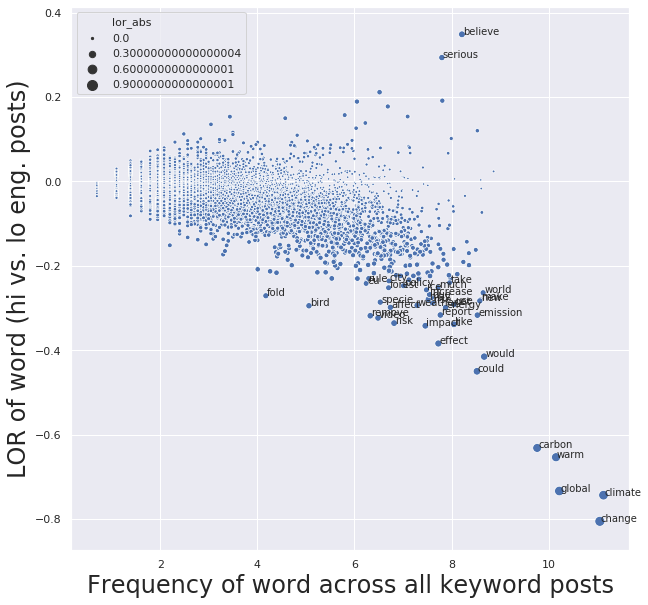

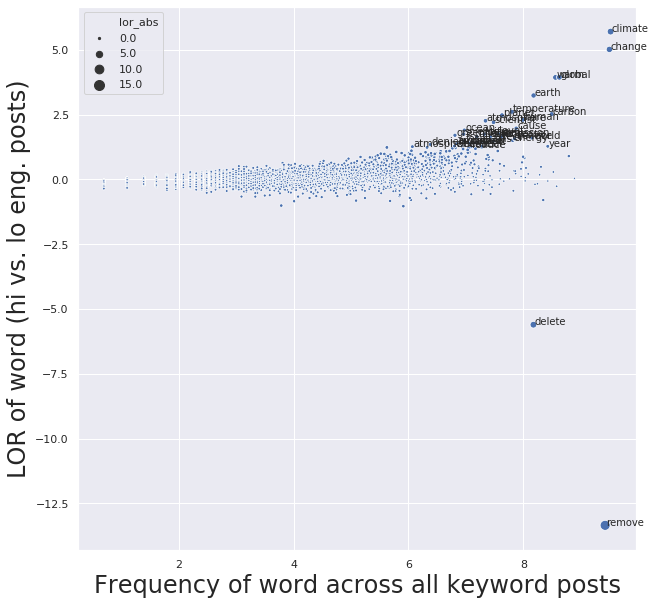

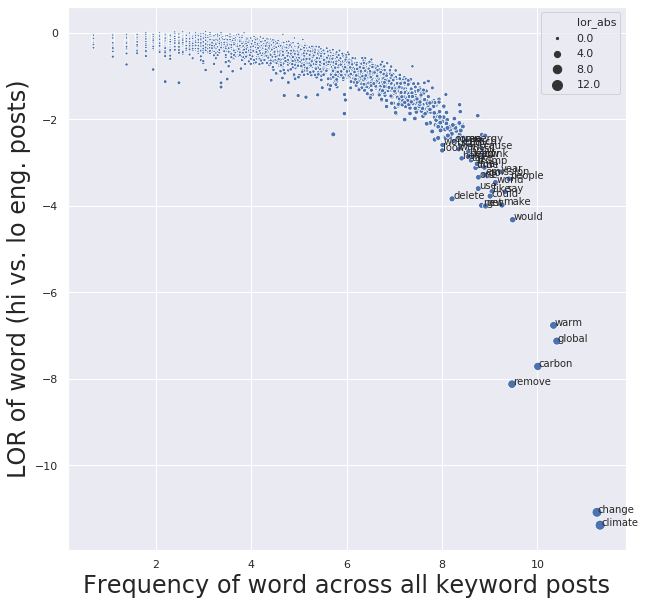

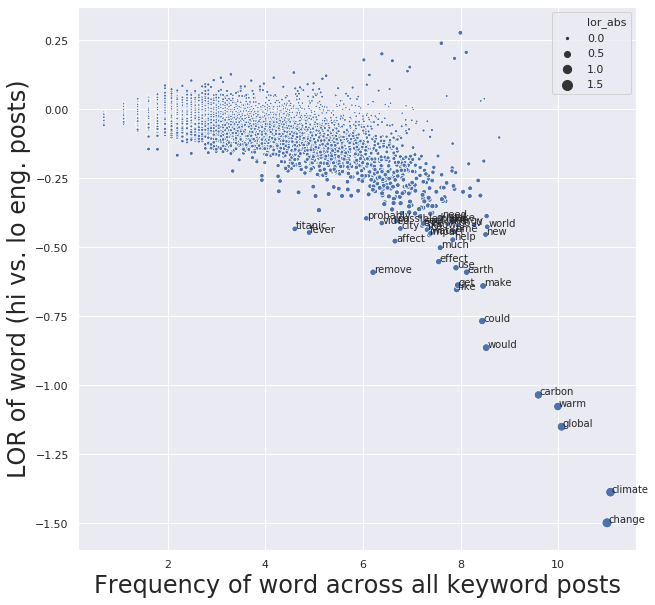

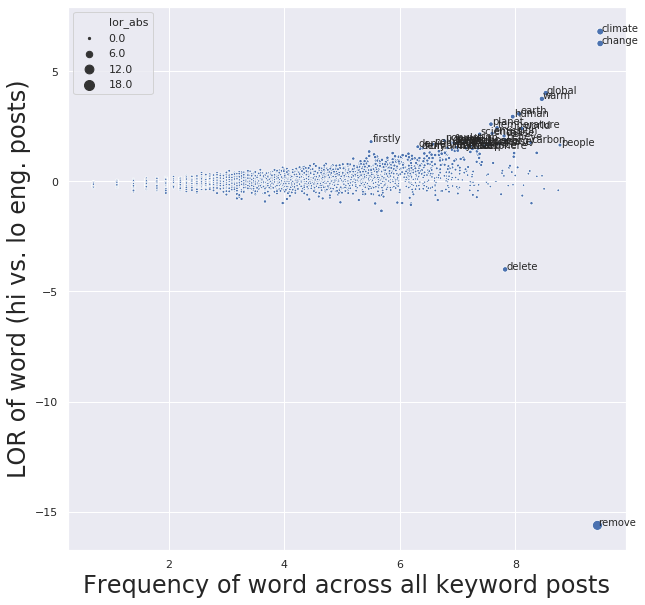

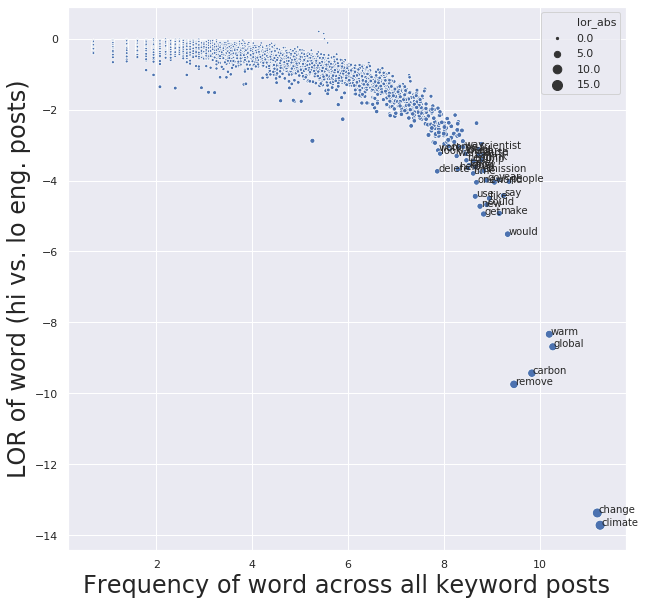

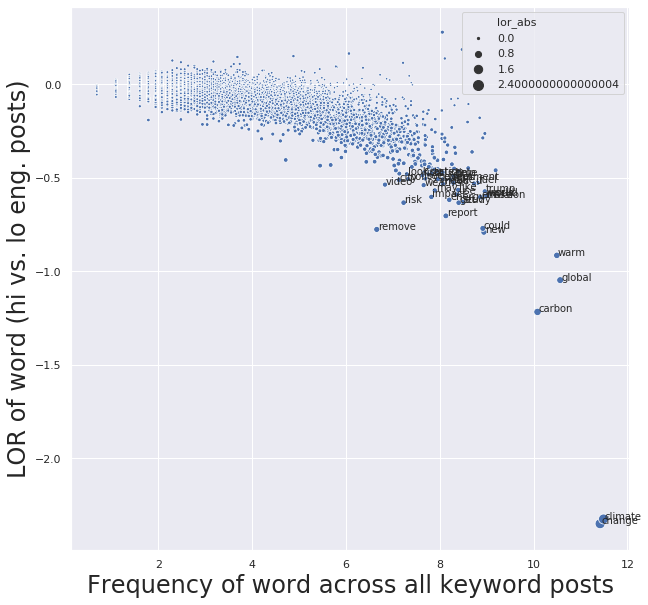

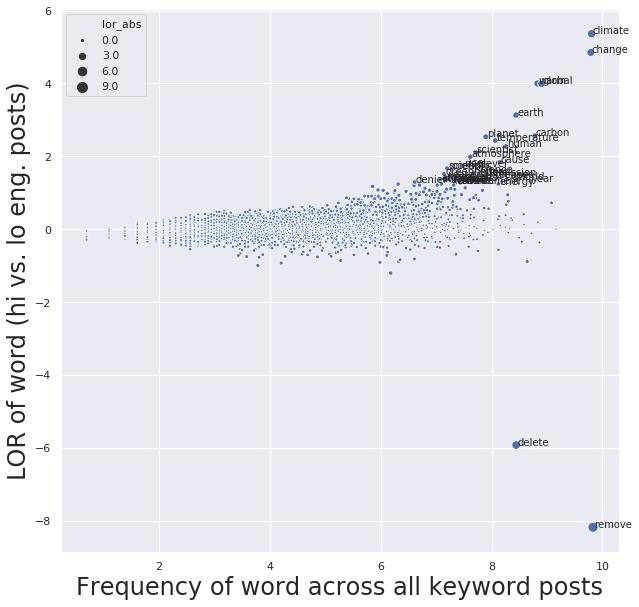

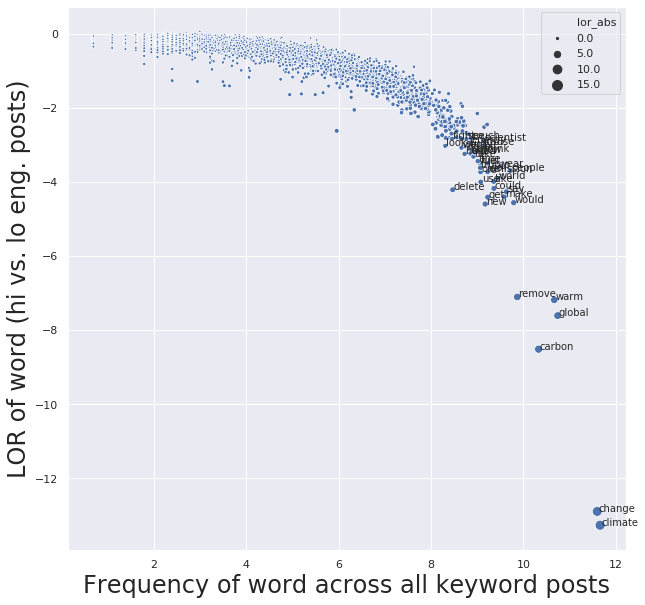

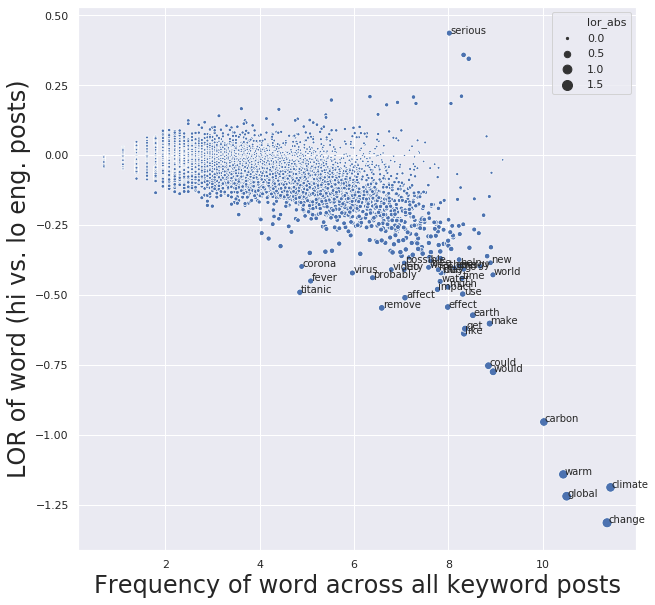

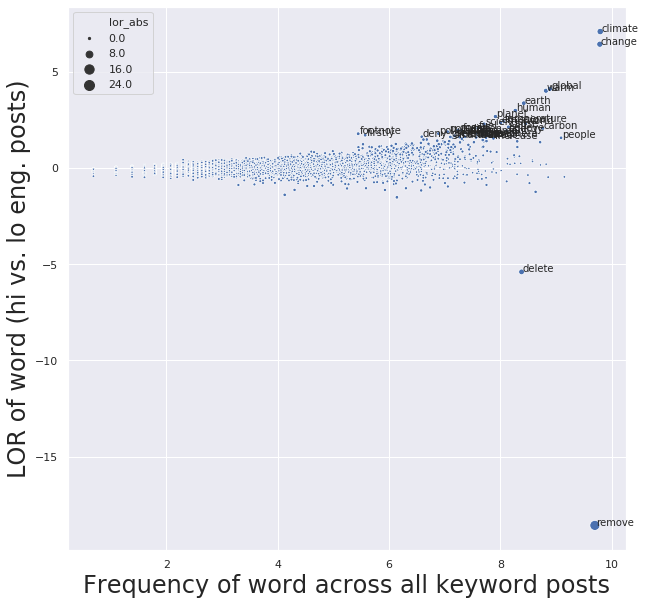

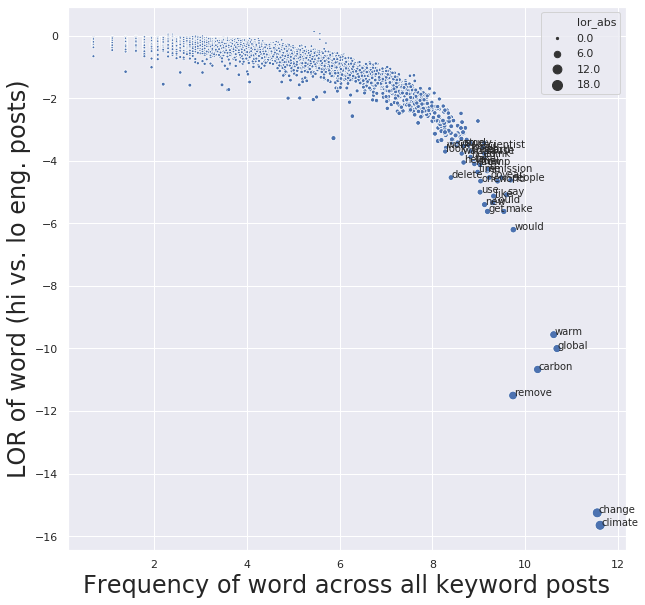

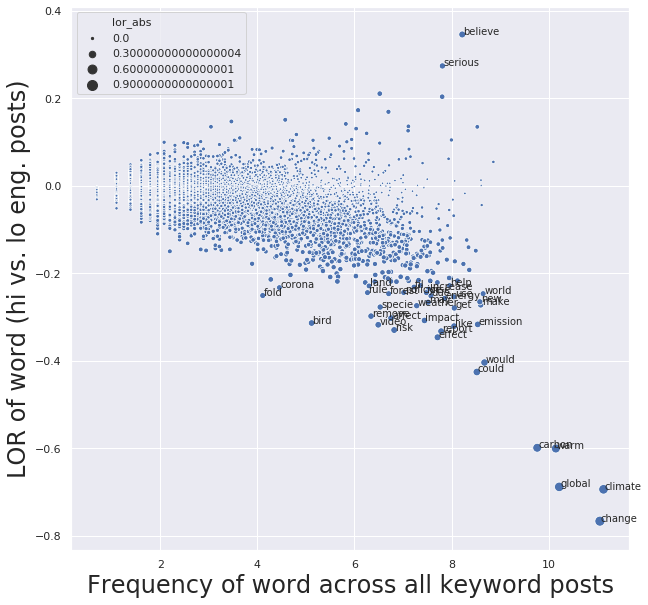

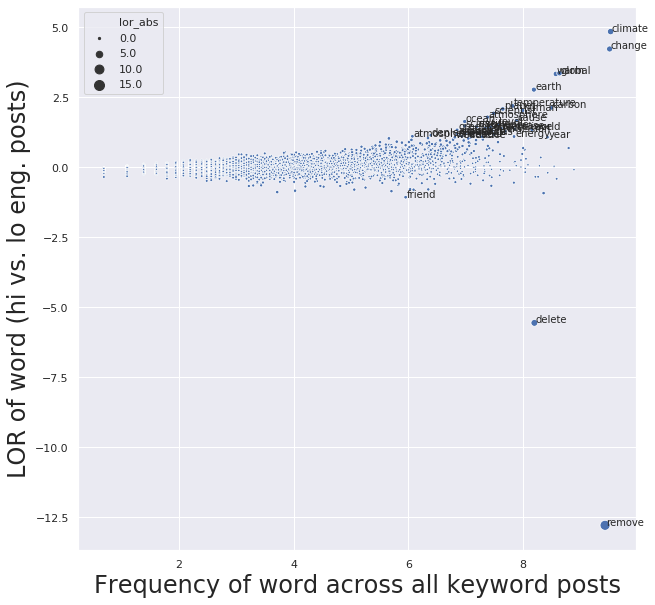

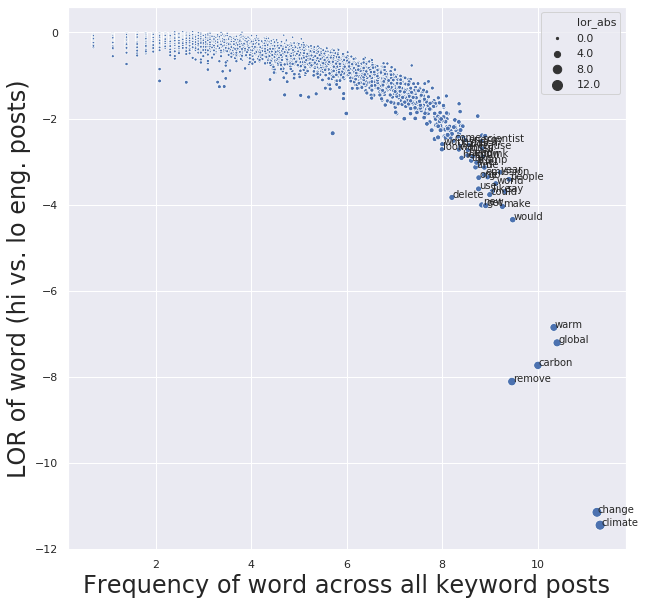

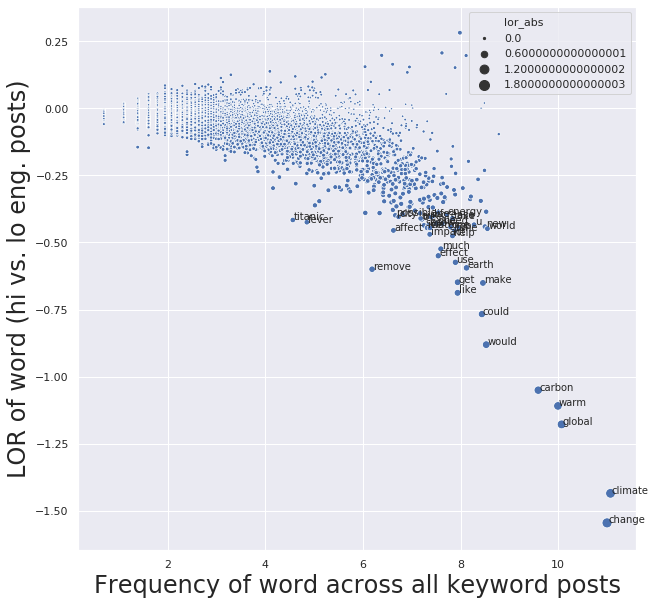

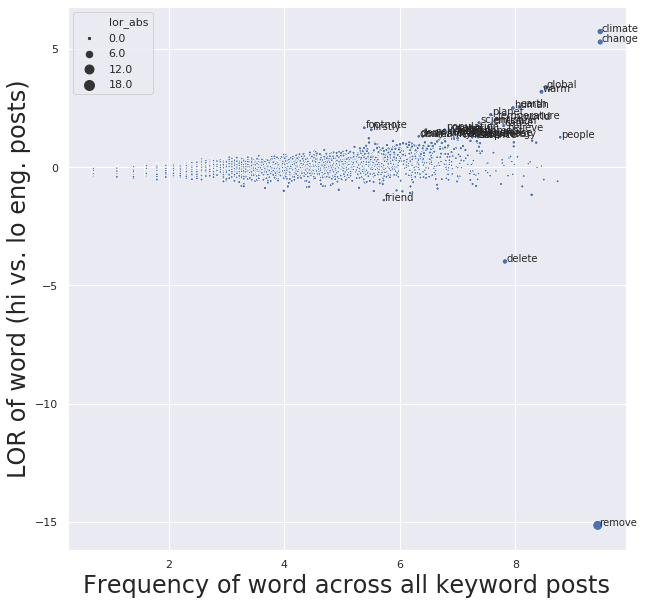

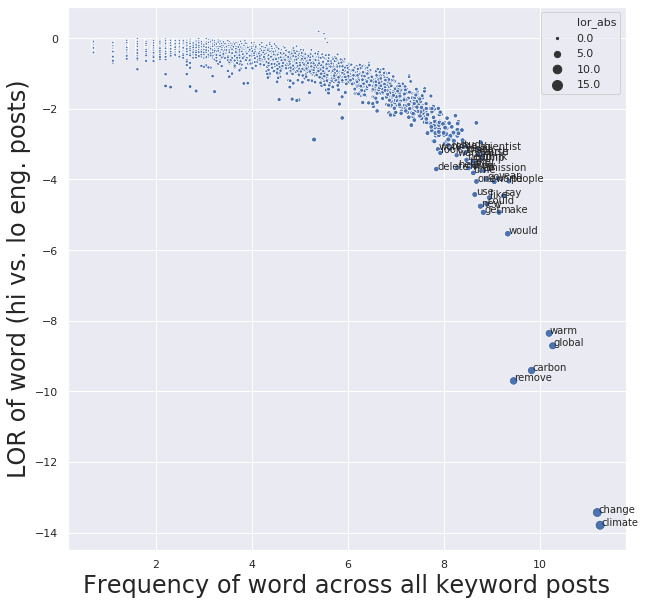

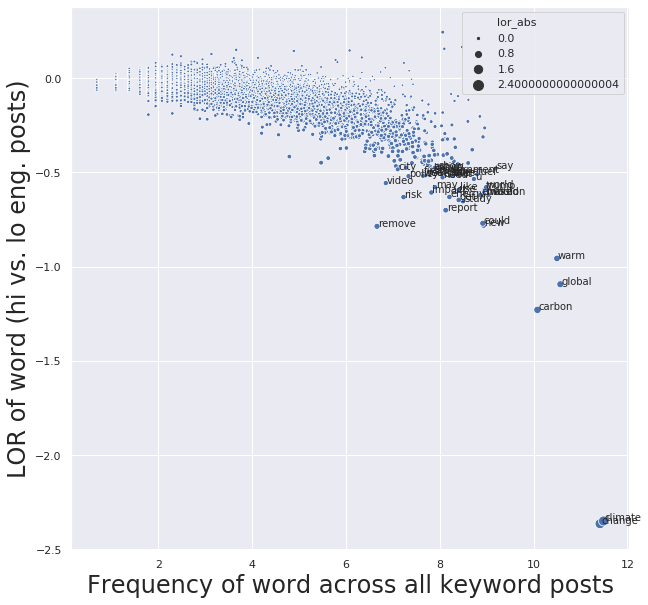

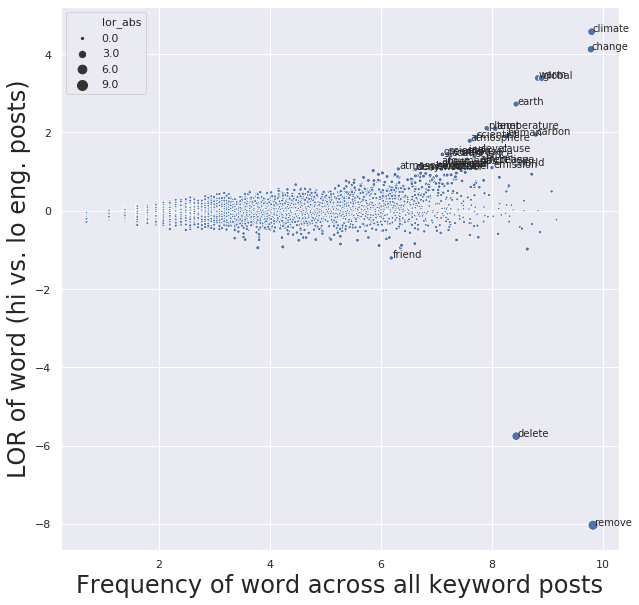

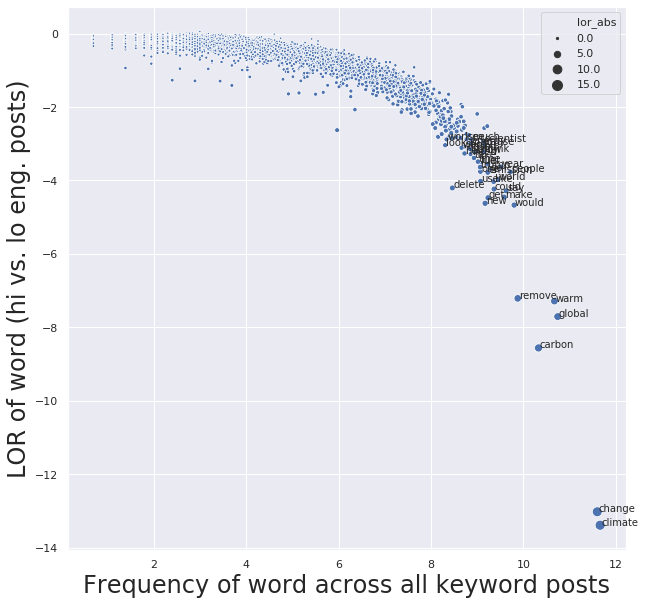

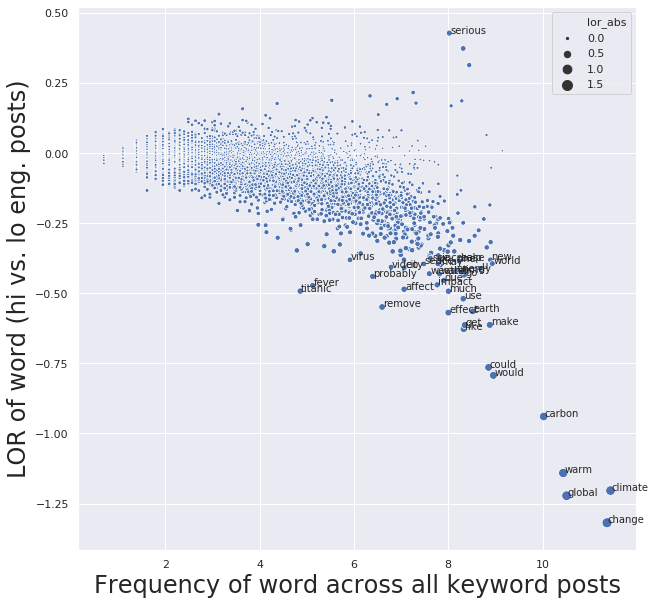

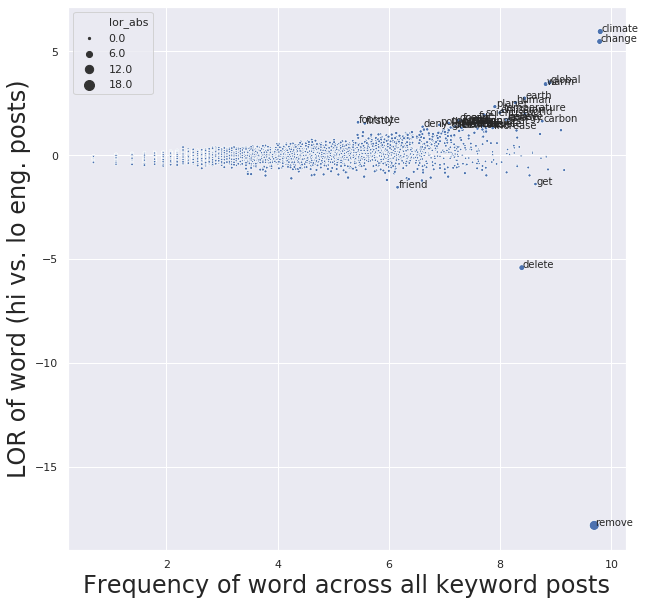

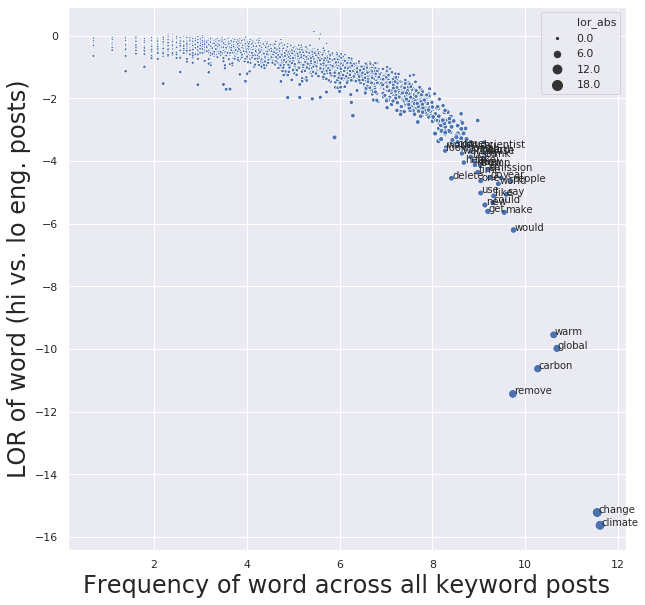

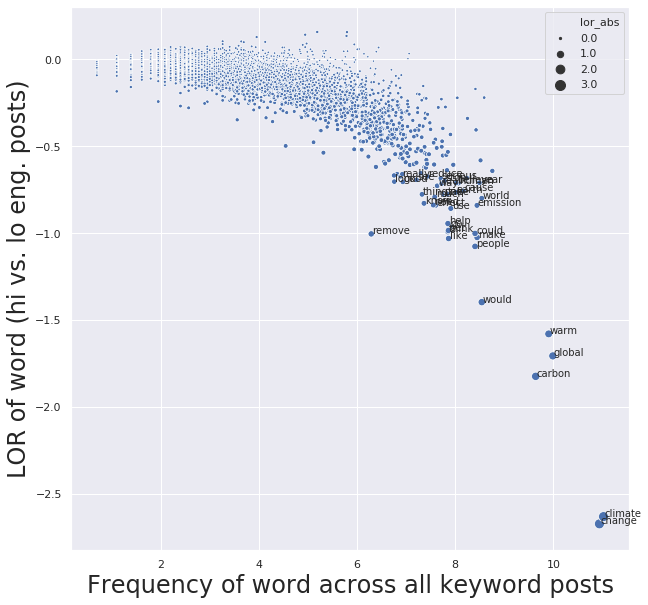

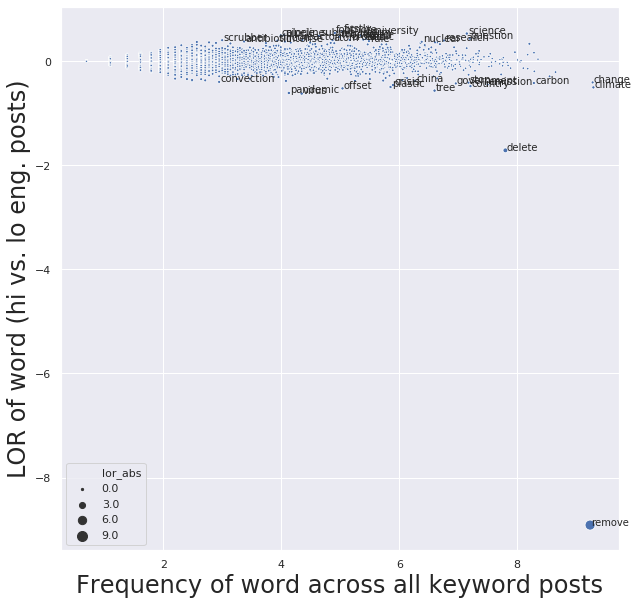

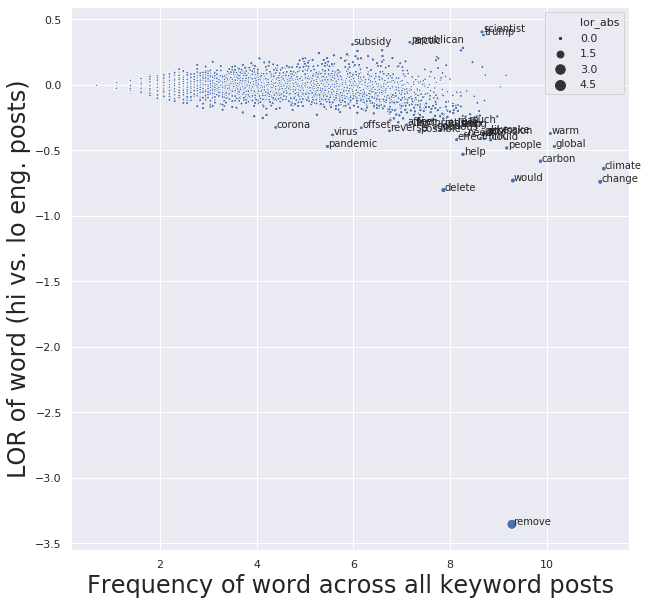

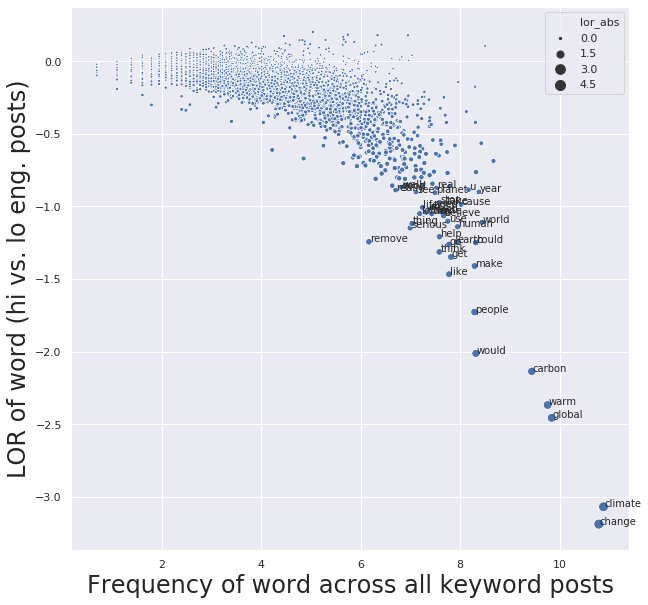

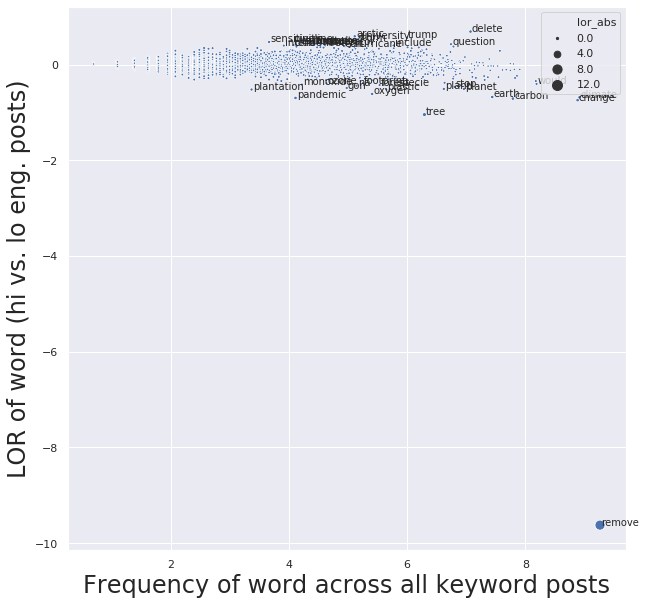

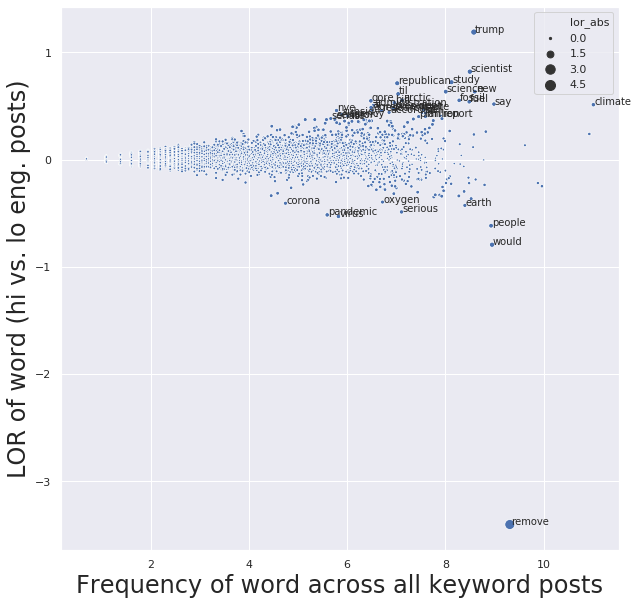

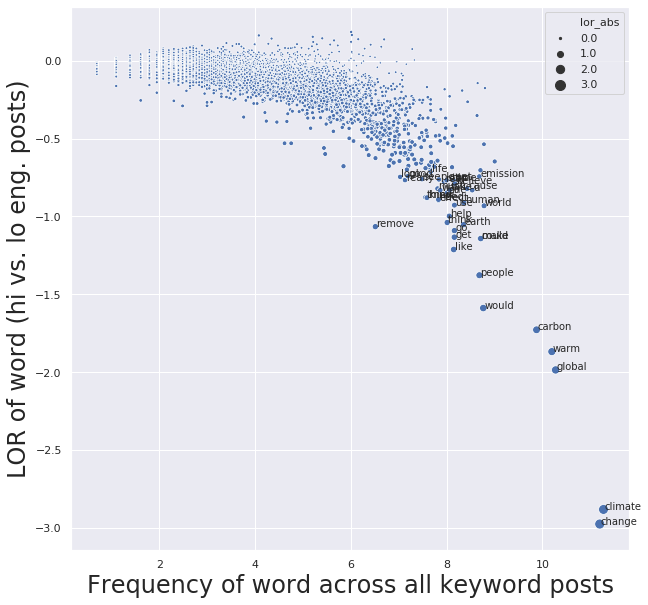

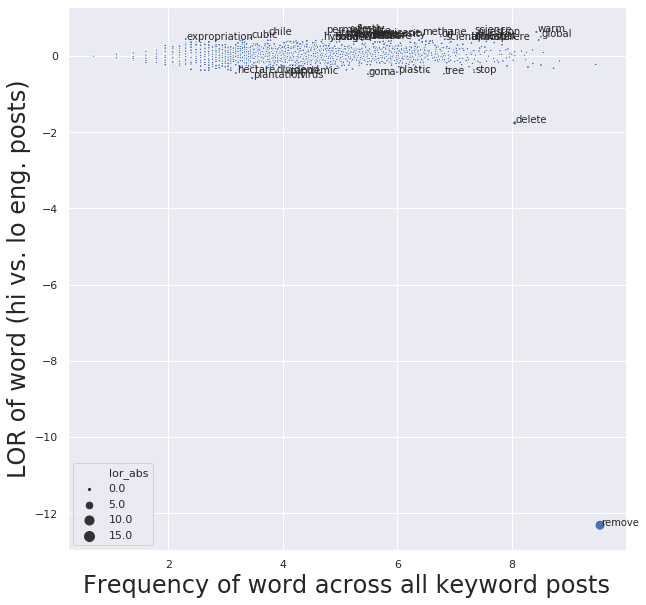

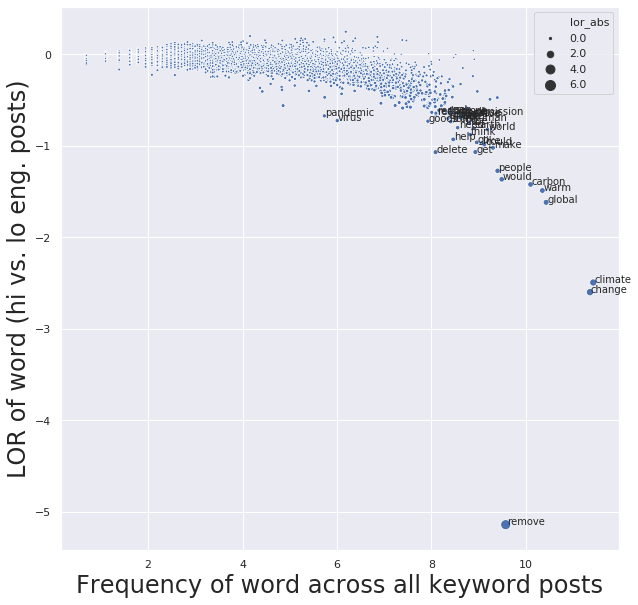

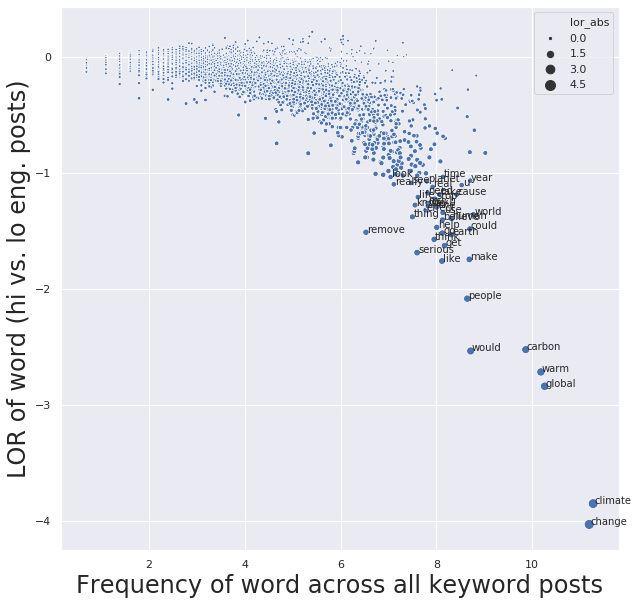

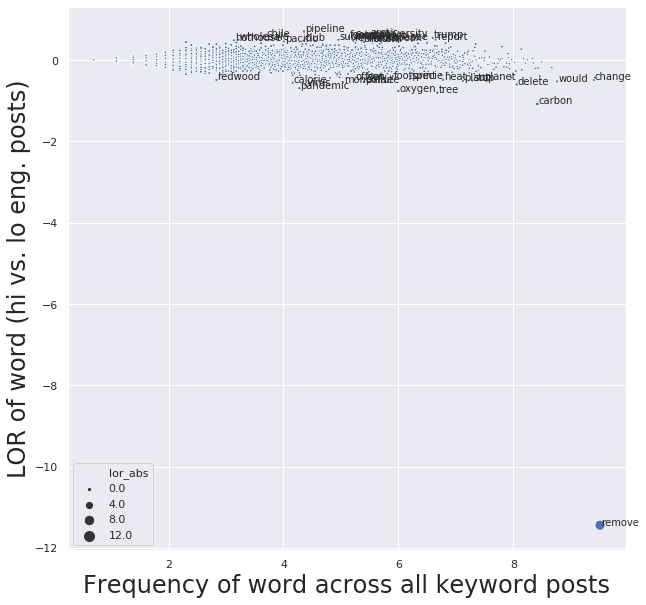

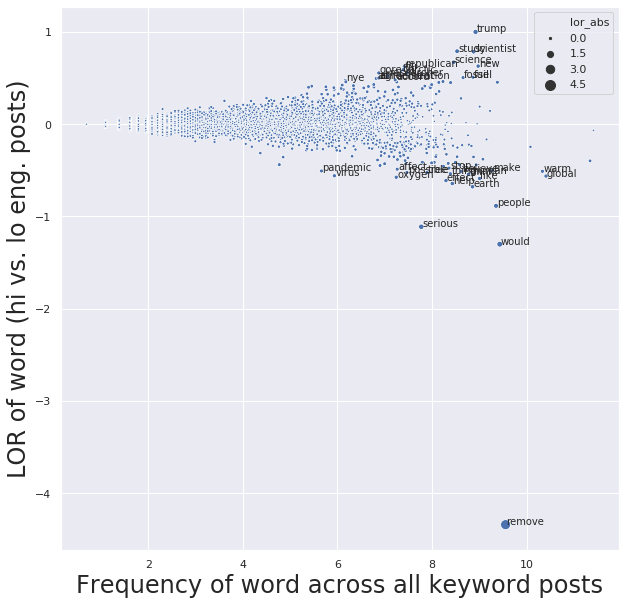

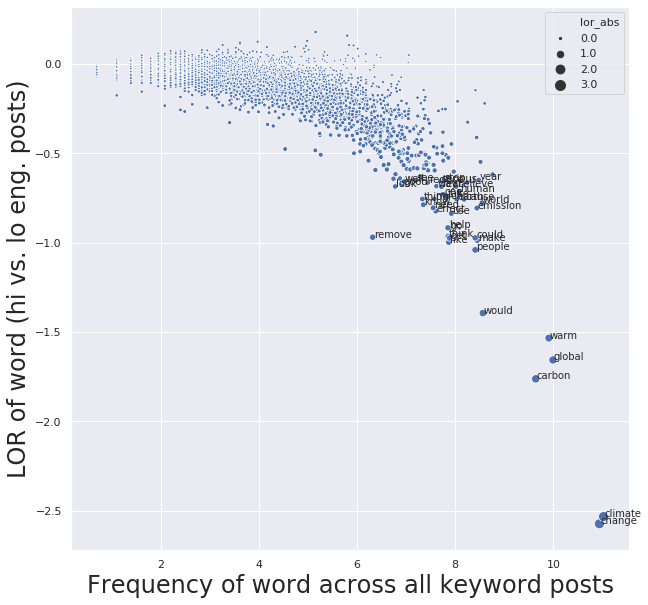

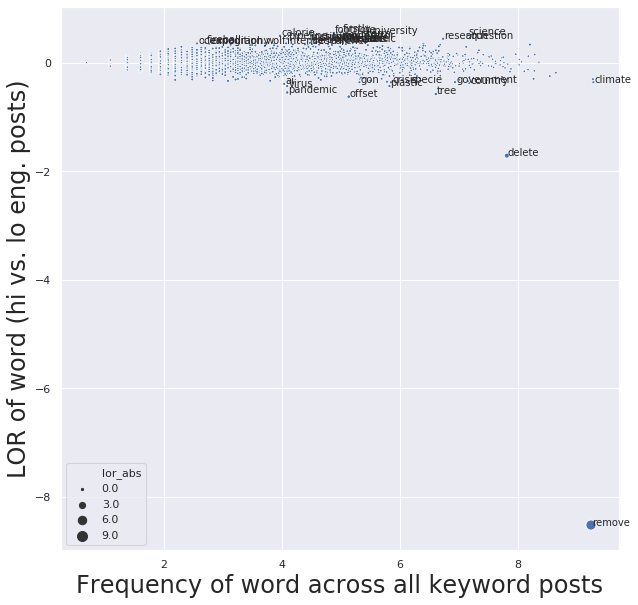

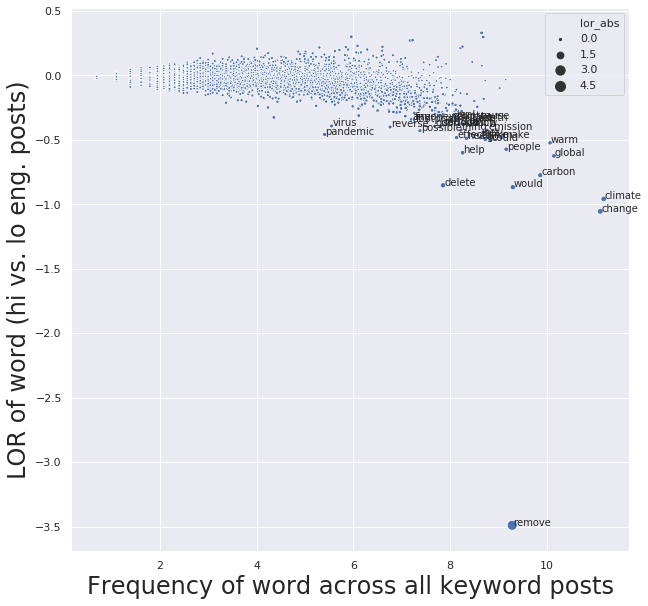

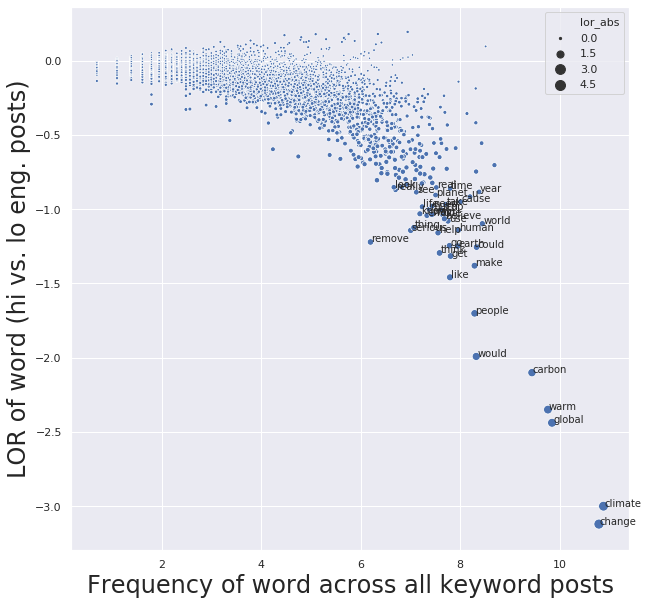

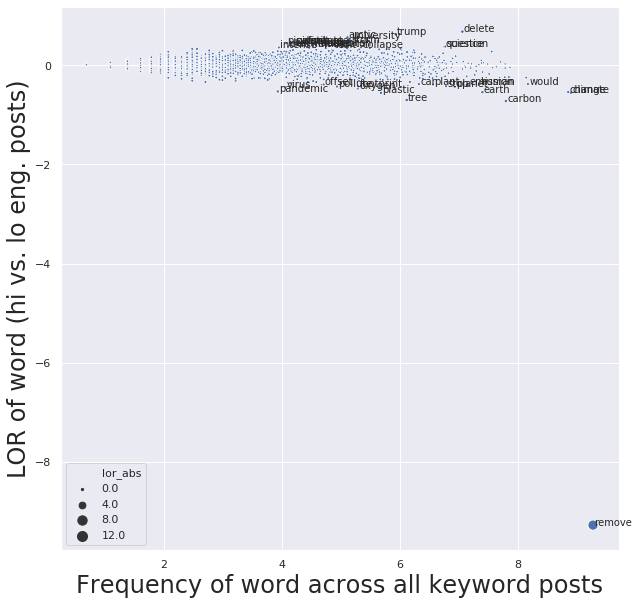

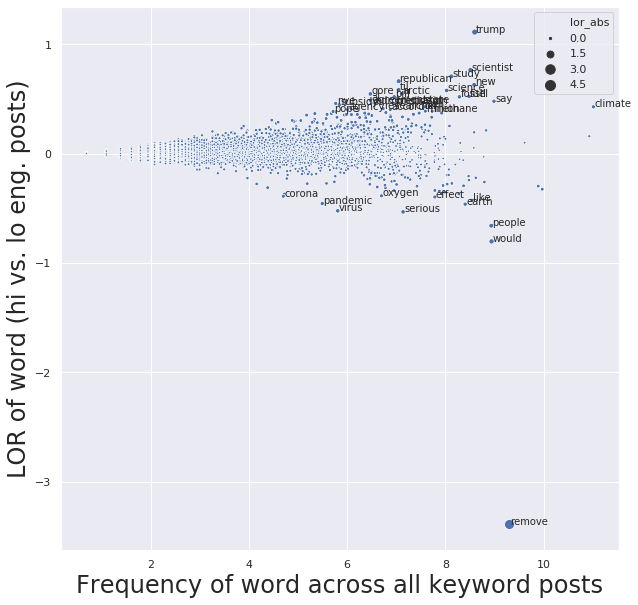

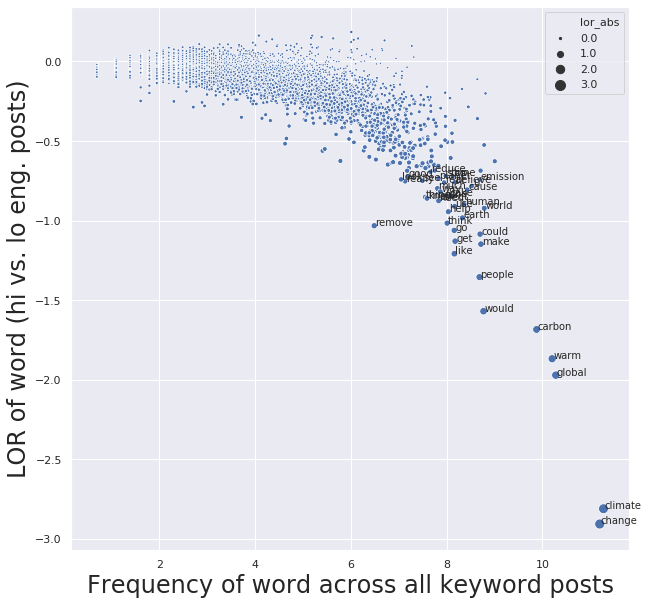

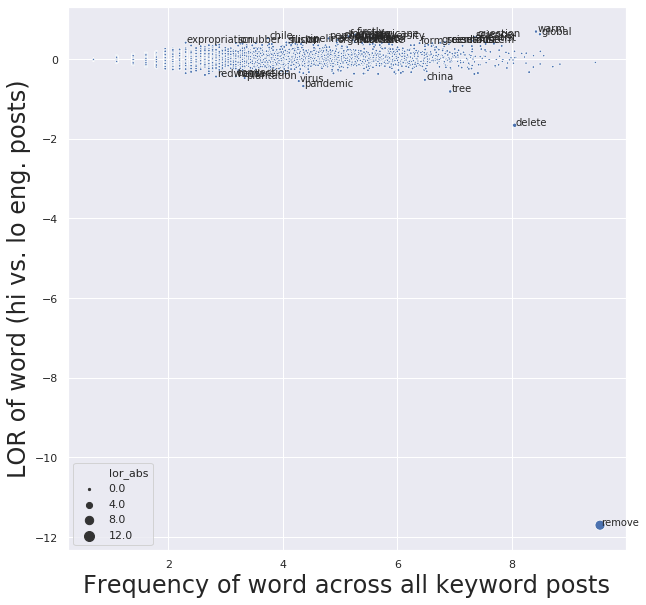

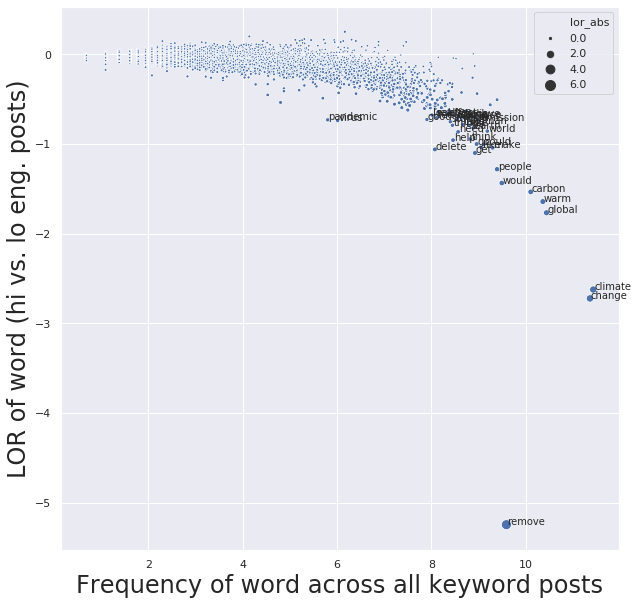

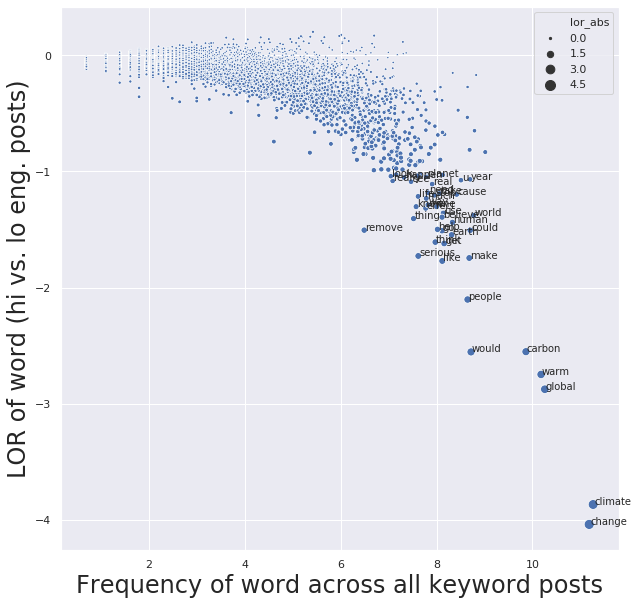

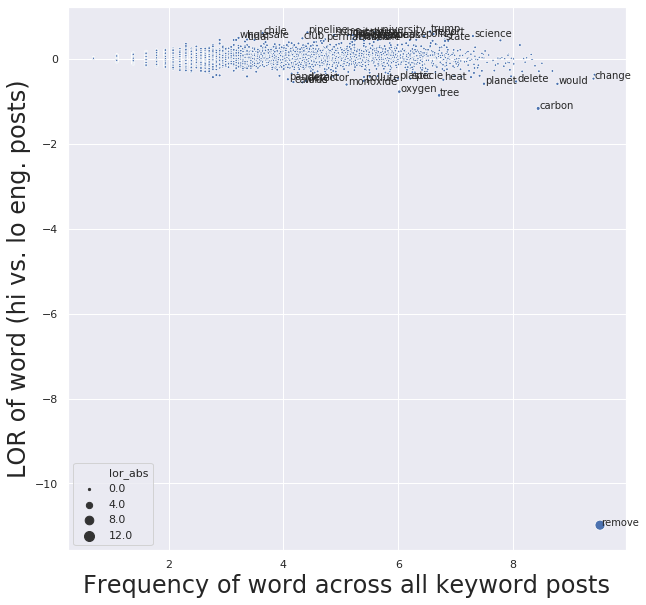

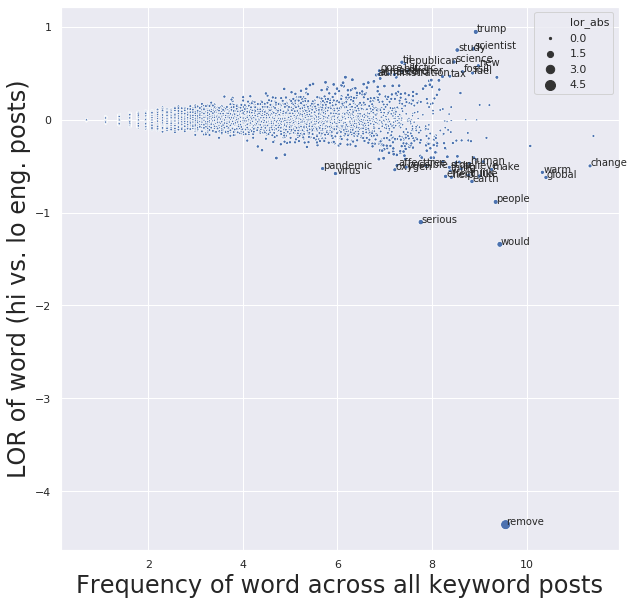

In [364]:
for base_df_type in ['general']:#BASE_DFS:
    base_df = BASE_DFS[base_df_type]
    
    for signal_type in ['log_num_comments','log_score']:
        print('Analyzing {} posts, using {} as engagement signal'.format(
                    base_df_type.upper(),signal_type))
    
        for do_non_zero in ['exclude_0','include_0']:
            if do_non_zero == 'exclude_0':
                base_df = base_df.loc[base_df[signal_type[4:]] > 0]
                print('\tPosts with 0 engagement are: {}'.format(
                    do_non_zero[:-2]+'d'))
                print('\tLength of base_df:',len(base_df))
                
            for middle_treatment in ['exclude_middle_third','include_middle']:
                if middle_treatment == 'exclude_middle_third':
                    std_factor = 0.33
                    exclusion_factor = 0.33
                    print('\t\tPosts with middle third engagement are *EX*cluded')
#                 elif middle_treatment == 'exclude_middle_quarter':
#                     std_factor = 0.25
#                     exclusion_factor = 0.25
#                     print('\t\tPosts with middle quarter engagement are *EX*cluded')
#                 elif middle_treatment == 'exclude_middle_tenth':
#                     std_factor = 0.1
#                     exclusion_factor = 0.1
#                     print('\t\tPosts with middle tenth engagement are *EX*cluded')
                else:
                    std_factor = 0
                    exclusion_factor = 0
                    print('\t\tPosts with middle engagement are *IN*cluded')
                
                for partition_type in ['rel','abs']:
                    if partition_type == 'rel':
                        print('\t\t\tCreating relative partition...')
                        partition = partition_lo_hi_posts_relative(base_df,signal_type,std_factor_=std_factor)
                    else:
                        print('\t\t\tCreating absolute partition...')
                        mean_ = base_df[signal_type].mean()
                        lo_ = mean_
                        hi_ = mean_ + 0.01
                        partition = partition_lo_hi_posts_absolute(base_df,signal_type,lo_,hi_,
                                                                   exclusion_factor_=exclusion_factor)

                    for lemma_type in ['title_lemmas','body_lemmas','both']:
                        print('\t\t\t\tCalculating LOR for {}...'.format(lemma_type))
                        figure_savename = '{}_{}_{}_{}_{}_{}.png'.format(base_df_type,signal_type,do_non_zero,
                                                               middle_treatment,partition_type,lemma_type)
                        if lemma_type == 'title_lemmas':
                            N_BACKGROUND = N_BACKGROUND_TITLE_LEMS
                            VOCAB_COUNTS_BACKGROUND = VOCAB_COUNTS_BACKGROUND_TITLE
                        elif lemma_type == 'body_lemmas':
                            N_BACKGROUND = N_BACKGROUND_BODY_LEMS
                            VOCAB_COUNTS_BACKGROUND = VOCAB_COUNTS_BACKGROUND_BODY
                        else:
                            N_BACKGROUND = N_BACKGROUND_TITLE_LEMS + N_BACKGROUND_BODY_LEMS
                            VOCAB_COUNTS_BACKGROUND = VOCAB_COUNTS_BACKGROUND_TITLE + VOCAB_COUNTS_BACKGROUND_BODY
                            
                        lor_df_ = lor_report(base_df,VOCAB_COUNTS_BACKGROUND,N_BACKGROUND,
                          set(partition['hi']),set(partition['lo']),lemma_type,figure_savename)
                        all_lors.append((base_df_type,signal_type,do_non_zero,middle_treatment,
                                         partition_type,lemma_type,lor_df_))
                        
pickle.dump(all_lors,open('all_LORS.pkl','wb'))

In [365]:
len(all_lors)

48

In [366]:
# without stop words
pd.concat([all_lors[curr_ix][-1].sort_values('lor_hi_to_lo',ascending=False)[:30][['word']].reset_index(
    drop=True,inplace=False) 
          for curr_ix in range(0,len(all_lors))],axis=1,ignore_index=True)

0            1               2              3            4  \
0         believe      climate          inflow            tax      climate   
1         serious       change   thermodynamic        serious       change   
2          sander       global         warming        believe       global   
3          denier         warm      fatalistic         sander         warm   
4            poll        earth          pollan         crisis        earth   
5    conservative  temperature       increment           poll        human   
6         breathe       carbon       signatory   conservative       planet   
7            hoax       planet        fireball         canada  temperature   
8           flesh        human   resuscitation           hoax        world   
9           mouth   atmosphere   interpersonal        premier     emission   
10       trillion    scientist           burry          arson    scientist   
11      execution        cause      elliptical       collapse        cause   
12           meat        ocean            quot           tony      believe   
13      scientist        level       twentieth         harper   population   
14          arson   scientific         nourish      execution       fossil   
15  unfalsifiable          ice   unfalsifiable           ford      firstly   
16          stein     emission    statistician          clive         rise   
17           cult   greenhouse        conflate  unfalsifiable       carbon   
18         crisis         rise        arguable      bombshell   scientific   
19      signatory     increase   industrialist          flesh        ocean   
20     disbelieve      science  semiconducting           cent         fuel   
21    nationalism        world       bourgeois         rebate  environment   
22    patriarchal      believe            otto            vow       energy   
23            nye       effect        nonmetal     compulsory    pollution   
24       disgrace       energy          fixate      signatory     increase   
25            ted       fossil          shriek       trillion       people   
26        mansion          gas        outspent       outspent        level   
27       unproven     evidence     bombardment    impassioned          ice   
28    impassioned         data      micrometer        handout       denier   
29           jane         fuel     endothermic        plummet          tax   

                5               6            7              8              9  \
0        footnote         serious      climate        maunder        serious   
1         firstly         believe       change  thermodynamic            tax   
2       moderator         breathe         warm  resuscitation        believe   
3      fatalistic           mouth       global      anthropic         crisis   
4        dogmatic           flesh        earth     fatalistic           poll   
5       anthropic          denier       carbon         feeble         canada   
6        outspent   resuscitation       planet      stoppable           tony   
7   sterilization       execution  temperature     nihilistic   conservative   
8            noel         deadpan        human       dogmatic           hoax   
9      comparably          oxygen    scientist  astonishingly         denier   
10        equable           arson   atmosphere           noel         sander   
11  thermodynamic      disbelieve        cause       antibody          flesh   
12          borer        antibody          ice         inflow         harper   
13       deniable   unfalsifiable        level     elliptical       collapse   
14          flack          exhale         rise    noctilucent       believer   
15         pinker         mansion        ocean         regrow      execution   
16  objectionable         diamond   scientific        warming           ford   
17        dryness          retort      science       diatomic      bombshell   
18            elk            poll   greenhouse        hogwash        premier 

In [368]:
# without stop words
pd.concat([all_lors[curr_ix][-1].sort_values('lor_hi_to_lo',ascending=False)[-30:][['word']].reset_index(
    drop=True,inplace=False) 
          for curr_ix in range(0,len(all_lors))],axis=1,ignore_index=True)

0          1         2        3          4         5         6  \
0      world     police     think        u    curious     think       one   
1   increase     parent      need       go       bike      need      city   
2       fold     wonder      know     tree      month     trump      fuel   
3        due       work      help    world   religion      take      take   
4        may      night      take     know       week      fuel         u   
5       make        day     trump     city        sex      know      need   
6        new       week      fuel  titanic       work      help     video   
7     specie       bank         u      ice      night         u   weather   
8       rise        sex      time     time     thanks    delete      like   
9        use       song      year    fever    college  emission       may   
10       get     advice  emission    water       song      time     trump   
11   weather      woman        go      new      woman      year       use   
12      bird      month       one   impact      music        go     world   
13    affect      music    people     help       tank    people     would   
14    energy    calorie     world   affect     advice       one    impact   
15    report    atheist       use     much      movie     world  emission   
16  emission      movie      like   effect        ask       say      make   
17    remove       love       say      use        god       use    energy   
18     video       tank     could    earth  oligarchy      like     study   
19      risk        god    delete   remove       game     could      risk   
20      like        guy      make      get     school       new       get   
21    impact     school       new     make       love      make    report   
22    effect        get       get     like       girl       get     could   
23     would       game     would    could        get     would    remove   
24     could      story      warm    would      story      warm       new   
25    carbon       girl    global   carbon        guy    global      warm   
26      warm  oligarchy    carbon     warm     wonder    carbon    global   
27    global     friend    remove   global     friend    remove    carbon   
28   climate     delete    change  climate     delete    change   climate   
29    change     remove   climate   change     remove   climate    change   

            7         8         9         10        11        12          13  \
0       night     think        go       bike     think      rise        bike   
1     contact      know      city       know      need     world        play   
2        week      need     video       week      take    forest         sex   
3      parent      help       ice      night      help      fold         job   
4        play      take       due       bank      fuel       due        week   
5        song      time       may      month      know       use         day   
6        tank      fuel     virus    college     trump    energy      wonder   
7        bank         u     world       song         u       new        bank   
8         day      year  probably     thanks  emission       may        song   
9         sex     trump      time      woman      time      make       month   
10        god        go     fever       work        go   weather  plantation   
11     advice    people     water      music    delete    specie     atheist   
12      month  emission      much    atheist      year       get        work   
13    atheist       one    impact      movie    people    remove      advice   
14      woman     world   titanic       tank       one    affect       woman   
15    calorie      like       use     advice     world    impact       music   
16      music       use    affect        ask       use      bird        tank   
17      movie     could    effect     wonder       say  emission       movie   
18      chile    delete    remove        god      like     video         god   
19        guy       say

In [361]:
# With stop words
pd.concat([all_lors[curr_ix][-1].sort_values('lor_hi_to_lo',ascending=False)[-30:][['word']].reset_index(
    drop=True,inplace=False) 
          for curr_ix in range(0,len(all_lors))],axis=1,ignore_index=True)

0       1        2        3       4        5        6       7  \
0        if      so       my      can    just      how    about      so   
1        my    want      not     will    like       my       my  friend   
2     would     out    about       or    know    about       or   would   
3        by      in       if      but      so     from     will    just   
4      will    just     from     from     the       if       by    like   
5       but  friend     what    would   would     what      you     but   
6        or     but       we      how      in       we      but      in   
7        we    like     this     this     but     this       we      or   
8      from      or     with     with      or     with     from     the   
9        do      he   remove       if    your   remove     with      he   
10     this      it      you       do    with      you       do     her   
11     with    with     warm       we      he     warm     this     she   
12     have     get   global     have     her   global     warm    your   
13     warm     her       do     warm      it       do   global    with   
14   carbon    your   carbon   carbon     get       on     have     get   
15     that     she     have       on     she   carbon   carbon      it   
16      for    what       on      for     for     have     that      me   
17   global      me      for   global      me      for      for    what   
18       on     for     that     that    what     that       on     for   
19       it      be       it       it     and       it       it    have   
20        i     and        i       in    have        i        i      do   
21       in    have       in        i      to       in       in      be   
22  climate      to   change  climate      do   change      and     and   
23   change      do      and   change      be      and       of      to   
24       of      my  climate      and  delete  climate   change      my   
25      and     you       of       of     you       of  climate     you   
26        a       a        a        a      my        a        a       a   
27       to  delete       to       to       a       to       to  delete   
28       be       i       be       be       i       be       be       i   
29      the  remove      the      the  remove      the      the  remove   

          8        9      10       11       12      13       14       15  \
0       but       my    just       my       my   would      but      can   
1        if       or    like      not       if      so      not     will   
2     about      but    know    about    would    just    about       or   
3       not     will      so     from       by      of       if      but   
4      from    would   would       if     will    like     from    would   
5    remove      how     but     what      but     but     what     from   
6      what     from      or       we       or      or       we      how   
7        we       do      in     this       we      he     this     this   
8      this     this     her     with       do     her     with     with   
9      with     with    your      you     from      in   remove       if   
10      you       if      he   remove     this     she      you       do   
11     warm       we     she     warm     with    your     warm       we   
12   global     have    with   global     have     get   global     have   
13       do   carbon     the       do     warm    with       do     warm   
14   carbon     warm     get   carbon   carbon      me   carbon   carbon   
15     have     that      it     have     that    what     have      for   
16       on       on      me       on   global      it       on       on   
17     that      for    what      for      for     the      for   global   
18      for   global     for     that       on     for     that     that   
19       it       it    have       it       it    have       it       it   
20        i       in     and        i        i      do        i       in   
21       in 

## LOR words in comments of high vs. low engagement posts

In [244]:
known_post_ids = set(comment_ids_per_post['post_id'])
len(known_post_ids)

112365

In [245]:
known_posts_df = posts_df.loc[posts_df['id'].isin(known_post_ids)]
known_posts_df.shape

(107240, 22)

In [249]:
# comment_texts_df = pd.read_csv('text_per_comment.tsv',sep='\t',header=0)
# comment_texts_df.head(),comment_texts_df.shape

# comment_texts_df = comment_texts_df.loc[~pd.isnull(comment_texts_df.text)]
# print(comment_texts_df.shape)
# comment_texts_df['lemmas'] = comment_texts_df.text.apply(get_lemmas)

In [250]:
#comment_texts_df.to_pickle('lemmatized_comment_texts.pkl')
comment_texts_df = pd.read_pickle('reddit_data/lemmatized_comment_texts.pkl')

In [251]:
comment_id2lemmas = dict(zip(comment_texts_df['comment_id'],
                            comment_texts_df['lemmas'].apply(lambda x: json.loads(x))))

In [252]:
comment_id2lemmas['d7fdpm4']

['that',
 "'s",
 'fair',
 '.',
 'thank',
 'you',
 'for',
 'have',
 'the',
 'courtesy',
 'to',
 'explain',
 'it',
 '.']

In [253]:
def lor_report_comments(df_,background_vocab_counts,N_back,g1_indices,g2_indices,X_str,savename,n_to_label=40):
    
    # Get X for groups 1 and 2
    print('Partitioning data into groups')
    if True:#X_str == 'both':
        # g1, g2 are post indices for hi, lo engagement
        
        # go from post to comment indices:
        g1_posts = df_.loc[df_['id'].isin(g1_indices)]
        g2_posts = df_.loc[df_['id'].isin(g2_indices)]
        
        g1_comm_ids = [post2comment_ids[p_id] for p_id in g1_posts['id']] # list of lists
        g1_comm_ids = [item for sublist in g1_comm_ids for item in sublist] # flat list
        
        g2_comm_ids = [post2comment_ids[p_id] for p_id in g2_posts['id']] # list of lists
        g2_comm_ids = [item for sublist in g2_comm_ids for item in sublist] # flat list
        
        # then go from comment indices to comment lemmas
        g1_comm_lemmas = [comment_id2lemmas[comm_id] for comm_id in g1_comm_ids
                         if comm_id in comment_id2lemmas] # list of lists
        g1_comm_lemmas = [item for sublist in g1_comm_lemmas for item in sublist]
        
        g2_comm_lemmas = [comment_id2lemmas[comm_id] for comm_id in g2_comm_ids
                         if comm_id in comment_id2lemmas] # list of lists
        g2_comm_lemmas = [item for sublist in g2_comm_lemmas for item in sublist]
    else:
        hi_eng_title_lems = [json.loads(p[X_str]) for _,p in df_.iloc[g1_indices].iterrows() 
                            if p[X_str] is not None]
        lo_eng_title_lems = [json.loads(p[X_str]) for _,p in df_.iloc[g2_indices].iterrows()
                            if p[X_str] is not None]
#     hi_eng_title_lems = [item for sublist in hi_eng_title_lems for item in sublist]
#     lo_eng_title_lems = [item for sublist in lo_eng_title_lems for item in sublist]
    hi_eng_title_lems = g1_comm_lemmas
    lo_eng_title_lems = g2_comm_lemmas
    
    # Exclude non-alpha
    hi_eng_title_lems = [x for x in hi_eng_title_lems if x.isalpha()]
    lo_eng_title_lems = [x for x in lo_eng_title_lems if x.isalpha()]
    print("Excluding non-alpha tokens. Number of tokens in 2 post groups:",len(hi_eng_title_lems),len(lo_eng_title_lems))
    N_hi, N_lo = len(hi_eng_title_lems), len(lo_eng_title_lems)
    
    # Exclude non-nltk words
    hi_eng_title_lems = [x for x in hi_eng_title_lems if x in WORDS]
    lo_eng_title_lems = [x for x in lo_eng_title_lems if x in WORDS]
    print("Excluding non-nltk words. Number of tokens in 2 post groups:",len(hi_eng_title_lems),len(lo_eng_title_lems))
    N_hi, N_lo = len(hi_eng_title_lems), len(lo_eng_title_lems)
    N_back += N_hi
    N_back += N_lo
    
    hi_eng_title_vocab = set(hi_eng_title_lems)
    lo_eng_title_vocab = set(lo_eng_title_lems)
    print("Vocab size of hi, lo engagement posts:",len(hi_eng_title_vocab),len(lo_eng_title_vocab))
    
    joint_vocab = hi_eng_title_vocab.intersection(lo_eng_title_vocab)
    print('Size of joint vocab:',len(joint_vocab))
    print('Proportion of joint vocab in hi:',len(joint_vocab)/len(hi_eng_title_vocab))
    print('Proportion of joint vocab in lo:',len(joint_vocab)/len(lo_eng_title_vocab))
    
    vocab_counts_hi = Counter(hi_eng_title_lems)
    vocab_counts_lo = Counter(lo_eng_title_lems)
    background_vocab_counts += vocab_counts_hi
    background_vocab_counts += vocab_counts_lo
    L_O_R_dict = {w: log_odds_ratio_idp(vocab_counts_hi[w],N_hi,vocab_counts_lo[w],N_lo,
                                        background_vocab_counts[w],N_back)
             for w in joint_vocab}
    
    # Plot LOR[w] against its frequency (sum over counts in hi and lo corpora)
    lor_df = pd.DataFrame(L_O_R_dict.items())
    lor_df.columns = ['word','lor_hi_to_lo']
    lor_df['freq'] = [vocab_counts_hi[w]+vocab_counts_lo[w] for w in lor_df['word']]
    lor_df['log_freq'] = lor_df['freq'].apply(lambda x: np.log(x))
    lor_df['lor_abs'] = lor_df['lor_hi_to_lo'].apply(lambda x: abs(x))
    lor_df['background_freq'] = [background_vocab_counts[w] for w in lor_df['word']]
    lor_df['log_background_freq'] = lor_df['background_freq'].apply(lambda x: np.log(x))
    
    fig,ax = plt.subplots(figsize=(10,10))
    sns.scatterplot(x='log_freq',y='lor_hi_to_lo',data=lor_df,size="lor_abs",
                sizes=(5, 100), alpha=1)
    ax.set_xlabel('Frequency of word across all posts comments',fontsize=24)
    ax.set_ylabel('LOR of word (hi vs. lo eng. posts)',fontsize=24)

    df_to_label = lor_df.sort_values('lor_abs')[-1*n_to_label:]
    label_point(df_to_label['log_freq'], df_to_label['lor_hi_to_lo'], df_to_label['word'], ax)
    plt.savefig(os.path.join('figs',savename))
    
    return lor_df

In [255]:
base_df_ = known_posts_df.loc[(~known_posts_df.subreddit.isin(niche_subs)) &
                            (known_posts_df['num_comments'] > 0)]
base_df_.shape

(96631, 22)

In [254]:
base_df = known_posts_df.loc[(~known_posts_df.subreddit.isin(niche_subs)) &
                            (known_posts_df['num_comments'] > 0)]
base_df.reset_index(drop=True,inplace=True)
comm_partition1 = partition_lo_hi_posts_relative(base_df,'log_num_comments',std_factor_=0.33)

Partitioning 96631 posts in 7575 subreddits according to log_num_comments as engagement metric...
Number of low engagement posts: 43007
Number of high engagement posts: 26490


Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups: 4710766 322406
Excluding non-nltk words. Number of tokens in 2 post groups: 4534223 305012
Vocab size of hi, lo engagement posts: 20571 8567
Size of joint vocab: 8236
Proportion of joint vocab in hi: 0.40036945214136405
Proportion of joint vocab in lo: 0.9613633710750554


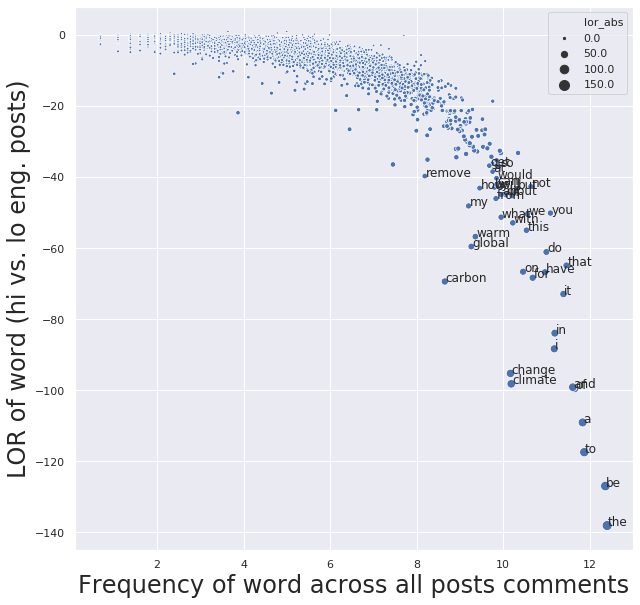

In [267]:
comm_lor_df_1 = lor_report_comments(base_df,VOCAB_COUNTS_BACKGROUND_BODY+VOCAB_COUNTS_BACKGROUND_TITLE,
                                    N_BACKGROUND_BODY_LEMS+N_BACKGROUND_TITLE_LEMS,
                                    comm_partition1['hi'],comm_partition1['lo'],
                                    'log_num_comments','lor_comments_rel_exclude_middle_third.png',n_to_label=40)

In [275]:
comm_lor_df_1.sort_values('lor_hi_to_lo',ascending=False)[:50]

word  lor_hi_to_lo  freq  log_freq   lor_abs  \
2275        overwrite      0.999021    38  3.637586  0.999021   
8024          sarcasm      0.982284   148  4.997212  0.982284   
1823         strawman      0.556360   119  4.779123  0.556360   
575          easement      0.533890    10  2.302585  0.533890   
3047            hooey      0.477872     8  2.079442  0.477872   
1916          germane      0.418549     7  1.945910  0.418549   
7663        attractor      0.391378     8  2.079442  0.391378   
4149    undereducated      0.384617     8  2.079442  0.384617   
2318      declarative      0.379370    13  2.564949  0.379370   
628       fissionable      0.352364     6  1.791759  0.352364   
7024        dynamical      0.342920    17  2.833213  0.342920   
6857               ah      0.240772   280  5.634790  0.240772   
5544      concomitant      0.187251     4  1.386294  0.187251   
6028             gish      0.166125    15  2.708050  0.166125   
7273         blowhard      0.164602    14  2.639057  0.164602   
1994            passe      0.160977     5  1.609438  0.160977   
4653        sloganeer      0.145594     4  1.386294  0.145594   
5846    zooxanthellae      0.141665     9  2.197225  0.141665   
2080             teat      0.133912    11  2.397895  0.133912   
4574          quibble      0.126800    17  2.833213  0.126800   
2021        semantics      0.117174    57  4.043051  0.117174   
6297  interventionist      0.109742    10  2.302585  0.109742   
1452        soundness      0.106252     4  1.386294  0.106252   
5982      equatorward      0.092940     3  1.098612  0.092940   
3184              naw      0.083768    18  2.890372  0.083768   
6954       ineptitude      0.075907    11  2.397895  0.075907   
4585         stepwise      0.067130     3  1.098612  0.067130   
5893     horribleness      0.059626     3  1.098612  0.059626   
7763      arbitrarily      0.055022    24  3.178054  0.055022   
578          disabuse      0.052560     3  1.098612  0.052560   
1895           legate      0.045676    13  2.564949  0.045676   
538           uncivil      0.043009   214  5.365976  0.043009   
7562    hydraulically      0.041715     5  1.609438  0.041715   
3198          erudite      0.033521     3  1.098612  0.033521   
1272              roi      0.033177    29  3.367296  0.033177   
5337          arbiter      0.025263     8  2.079442  0.025263   
6895              oaf      0.022279     3  1.098612  0.022279   
3099           oniony      0.022279     5  1.609438  0.022279   
1032       incivility      0.015186   396  5.981414  0.015186   
7234      equivalence      0.008356    21  3.044522  0.008356   
4091    condescension      0.003387    17  2.833213  0.003387   
5086            thump      0.001054    17  2.833213  0.001054   
3674             hurr      0.000528    22  3.091042  0.000528   
7257     unsurprising     -0.002480    12  2.484907  0.002480   
4806    precipitously     -0.008707     7  1.945910  0.008707   
1789    extrapolation     -0.016651    45  3.806662  0.016651   
3482          perturb     -0.018366     7  1.945910  0.018366   
7917       unobserved     -0.018833     3  1.098612  0.018833   
1884          instate     -0.023368     5  1.609438  0.023368   
596         proximate     -0.024015     9  2.197225  0.024015   

      background_freq  log_background_freq  
2275              219             5.389072  
8024             2229             7.709308  
1823             2101             7.650169  
575                56             4.025352  
3047               40             3.688879  
1916               35             3.555348  
7663               51             3.931826  
4149               52             3.951244  
2318               65             4.174387  
628                30             3.401197  
7024              216             5.375278  
6857             6541             8.785845  
5544               20             2.995732  
6028              211             5.351858  
7273              236     

Partitioning 96631 posts in 7575 subreddits according to log_score as engagement metric...
Number of low engagement posts: 48018
Number of high engagement posts: 43721
Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups: 4886863 643032
Excluding non-nltk words. Number of tokens in 2 post groups: 4699952 613343
Vocab size of hi, lo engagement posts: 20838 11320
Size of joint vocab: 10653
Proportion of joint vocab in hi: 0.5112294845954506
Proportion of joint vocab in lo: 0.941077738515901


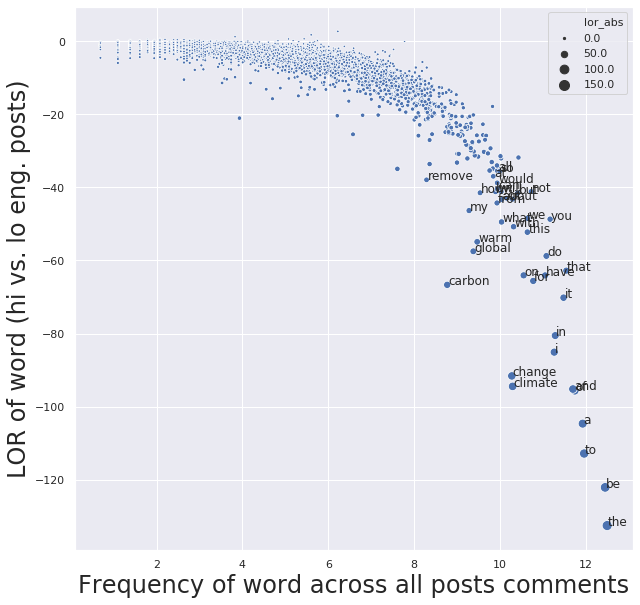

In [273]:
comm_partition2 = partition_lo_hi_posts_relative(base_df,'log_score',std_factor_=0)
comm_lor_df_2 = lor_report_comments(base_df,VOCAB_COUNTS_BACKGROUND_BODY+VOCAB_COUNTS_BACKGROUND_TITLE,
                                    N_BACKGROUND_BODY_LEMS+N_BACKGROUND_TITLE_LEMS,
                                    comm_partition2['hi'],comm_partition2['lo'],
                                    'log_score','lor_comments_rel_exclude_middle_third_score.png',n_to_label=40)

In [274]:
comm_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[:50]

word  lor_hi_to_lo  freq  log_freq   lor_abs  \
1362        incivility      2.692755   504  6.222576  2.692755   
712            uncivil      1.759933   271  5.602119  1.759933   
2966         overwrite      1.239450    46  3.828641  1.239450   
4400          resubmit      0.667569   230  5.438079  0.667569   
10388          sarcasm      0.633826   160  5.075174  0.633826   
5135          hindcast      0.590710     8  2.079442  0.590710   
4031            oniony      0.510635     9  2.197225  0.510635   
3951        reapproval      0.509502     6  1.791759  0.509502   
5584     repeatability      0.493359     8  2.079442  0.493359   
9205        pejorative      0.473042    12  2.484907  0.473042   
3021       declarative      0.462070    14  2.639057  0.462070   
764           easement      0.441019    11  2.397895  0.441019   
9921         attractor      0.398467     8  2.079442  0.398467   
3628        unstressed      0.348503     4  1.386294  0.348503   
10310         anathema      0.337542     8  2.079442  0.337542   
8901                ah      0.321408   312  5.743003  0.321408   
7838              gish      0.320316    16  2.772589  0.320316   
8978       supposition      0.314038    18  2.890372  0.314038   
8644   insubordination      0.277857     6  1.791759  0.277857   
3741             yucca      0.272125    20  2.995732  0.272125   
6011        phlogiston      0.267306     7  1.945910  0.267306   
9735        tropopause      0.214650    16  2.772589  0.214650   
2234            pander      0.204807   178  5.181784  0.204807   
10328            dowse      0.202840     6  1.791759  0.202840   
9431          implicit      0.189472   314  5.749393  0.189472   
4372         heterodox      0.182645     4  1.386294  0.182645   
8453            obtuse      0.180991    26  3.258097  0.180991   
57           logarithm      0.171365     9  2.197225  0.171365   
2387          strawman      0.169947   125  4.828314  0.169947   
2600             passe      0.167287     5  1.609438  0.167287   
5668            uppity      0.155668     7  1.945910  0.155668   
6016       consilience      0.142377     3  1.098612  0.142377   
1076            rescan      0.142377     3  1.098612  0.142377   
2362          lambaste      0.136589     4  1.386294  0.136589   
8566         facetious      0.131496    15  2.708050  0.131496   
702          primaried      0.130021     4  1.386294  0.130021   
2965         heretical      0.130015     7  1.945910  0.130015   
2637         semantics      0.126982    62  4.127134  0.126982   
8549     reorientation      0.123704     6  1.791759  0.123704   
8182   interventionist      0.120399    10  2.302585  0.120399   
4825           minutia      0.112281     7  1.945910  0.112281   
9957           ranting      0.110217     6  1.791759  0.110217   
1940           hackery      0.106465     3  1.098612  0.106465   
1040           venison      0.106309     5  1.609438  0.106309   
5933           quibble      0.103917    18  2.890372  0.103917   
791          proximate      0.100700     9  2.197225  0.100700   
1437      interjection      0.100597     4  1.386294  0.100597   
5113          evenness      0.096583     3  1.098612  0.096583   
9393      disastrously      0.095650     7  1.945910  0.095650   
7551          bleating      0.092975     7  1.945910  0.092975   

       background_freq  log_background_freq  
1362              1741             7.462215  
712               1109             7.011214  
2966               227             5.424950  
4400              1162             7.057898  
10388             2241             7.714677  
5135                30             3.401197  
4031                26             3.258097  
3951                18             2.890372  
5584                39             3.663562  
9205                94             4.543295  
3021                66             4.189655  
764                 57             4.043051  
9921                51             3.931826  
3628   

In [627]:
# no sub exclusion
#comm_lor_df_2 = lor_report_comments(known_posts_df,comm_partition2['hi'],comm_partition2['lo'],"")

In [628]:
#comm_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[-50:]

In [587]:
known_posts_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
comm_partition3 = partition_lo_hi_posts(known_posts_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 112365 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 44492
Number of high engagement posts: 67873


In [629]:
# no sub exclusion, use 1 as threshold
#comm_lor_df_3 = lor_report_comments(known_posts_df,comm_partition3['hi'],comm_partition3['lo'],"")

In [630]:
#comm_lor_df_3.sort_values('lor_hi_to_lo',ascending=False)[-50:]

Use 1 as threshold, now exclude niche subs

In [591]:
non_niche_df = known_posts_df.loc[~known_posts_df.subreddit.isin(niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
comm_partition4 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 101741 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 42269
Number of high engagement posts: 59472


In [631]:
#comm_lor_df_4 = lor_report_comments(non_niche_df,comm_partition4['hi'],comm_partition4['lo'],"")

In [632]:
#comm_lor_df_4.sort_values('lor_hi_to_lo',ascending=False)[-50:]

Same threshold of 1, now only include news general subs.

In [597]:
non_niche_df = known_posts_df.loc[known_posts_df.subreddit.isin(non_niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 1
HI_THRESH = 1.0005
comm_partition5 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 45156 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 19834
Number of high engagement posts: 25322


In [95]:
#non_niche_subs

In [633]:
#comm_lor_df_5 = lor_report_comments(non_niche_df,comm_partition5['hi'],comm_partition5['lo'],"")

In [634]:
#comm_lor_df_5.sort_values('lor_hi_to_lo',ascending=False)[-50:]

Increase threshold to 2

In [602]:
non_niche_df = known_posts_df.loc[known_posts_df.subreddit.isin(non_niche_subs)]
non_niche_df.reset_index(drop=True,inplace=True)
LO_THRESH = 2
HI_THRESH = 2.0005
comm_partition6 = partition_lo_hi_posts(non_niche_df,'log_num_comments',LO_THRESH,HI_THRESH)

Partitioning 45156 posts according to log_num_comments as engagement metric...
Number of low engagement posts: 30891
Number of high engagement posts: 14265


In [635]:
#comm_lor_df_6 = lor_report_comments(non_niche_df,comm_partition6['hi'],comm_partition6['lo'],"")

In [636]:
#comm_lor_df_6.sort_values('lor_hi_to_lo',ascending=False)[-50:]

# Log odds ratios of words in liberal vs. conservative posts

In [189]:
annotated_subs.cc_stance.value_counts()

n    26
p    23
a     4
Name: cc_stance, dtype: int64

In [190]:
sub2stance = dict(zip(annotated_subs['subreddit_name'].apply(lambda x: x[2:]),annotated_subs['cc_stance']))

In [191]:
sub2stance['ChapoTrapHouse'] = 'p'

In [192]:
subs_with_annots = set([x for x in sub2stance if sub2stance[x] is not None])
#subs_with_annots

In [193]:
annotated_df = posts_df.loc[(posts_df.subreddit.isin(subs_with_annots)) & (~posts_df.subreddit.isin(niche_subs))]
annotated_df.reset_index(inplace=True,drop=True)
len(annotated_df)
annotated_df['cc_stance'] = annotated_df.subreddit.apply(lambda x: sub2stance[x] if x in sub2stance else None)

liberal_df = annotated_df.loc[annotated_df.cc_stance=='p']
conservative_df = annotated_df.loc[annotated_df.cc_stance=='a']
neutral_df = annotated_df.loc[annotated_df.cc_stance=='n']

/u/nlp/anaconda/main/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 3340563 477580
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 3138910 443131
Vocab size of hi, lo engagement, background posts: 16766 9913 45835
Size of joint vocab: 9031
Proportion of joint vocab in hi: 0.5386496480973398
Proportion of joint vocab in lo: 0.9110259255523051


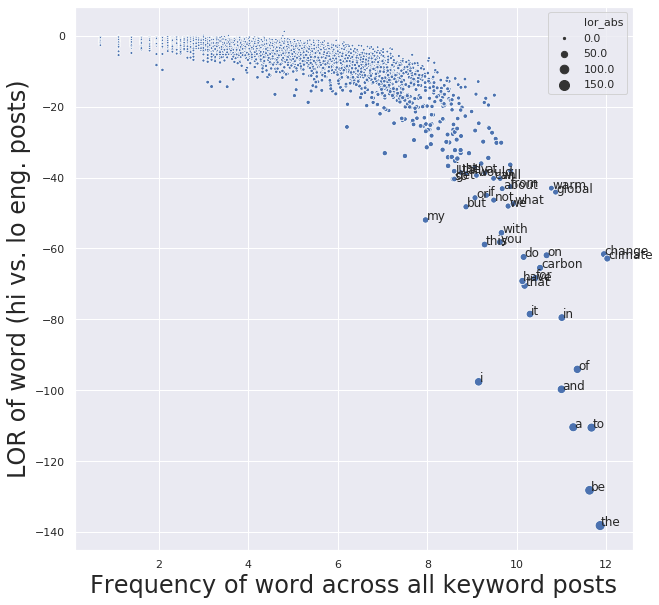

In [197]:
stance_lor_df_1 = lor_report(annotated_df,VOCAB_COUNTS_BACKGROUND_TITLE,N_BACKGROUND_TITLE_LEMS,
                             set(liberal_df['id']),set(conservative_df['id']),'title_lemmas',
                             'stance_lor_title_lemmas.png',
                             n_to_label=40)

In [198]:
# Most liberal post title words
stance_lor_df_1.sort_values('lor_hi_to_lo',ascending=False)[:50]

word  lor_hi_to_lo  freq  log_freq  background_freq  \
883            grist      1.275859   122  4.804021             1252   
848          censure      0.173801    20  2.995732              316   
3023          baobab      0.150657    35  3.555348              644   
5294      turbulence      0.092498   118  4.770685             2335   
1004           getup     -0.017063     6  1.791759               99   
4317          turney     -0.048114     3  1.098612               32   
4238         cowgate     -0.050962     2  0.693147                2   
5713            ashy     -0.083339     3  1.098612               41   
2075    anticipatory     -0.086836     3  1.098612               42   
7643      unburnable     -0.116195    17  2.833213              382   
2096           irene     -0.116195    15  2.708050              383   
7319        leighton     -0.134833     2  0.693147               20   
5019         quibble     -0.162173     5  1.609438              134   
8756   acceptability     -0.176538     2  0.693147               35   
1562        smuggery     -0.187293     3  1.098612               80   
3865    chairmanship     -0.188924     6  1.791759              180   
4328          assail     -0.192620     7  1.945910              213   
5728        glossary     -0.198743     6  1.791759              186   
466       unravelled     -0.199630     3  1.098612               86   
7284          waxman     -0.205608    16  2.772589              426   
8625          miasma     -0.212172     2  0.693147               51   
4306           gavel     -0.218914     3  1.098612               96   
3904      buffoonery     -0.220765     3  1.098612               97   
1117     metastasize     -0.222139     2  0.693147               56   
8624  obstructionism     -0.224427     3  1.098612               99   
5903            drub     -0.226002     2  0.693147               58   
6189          tipper     -0.226239     3  1.098612              100   
8417          possum     -0.227144    11  2.397895              358   
657        proximate     -0.227910     2  0.693147               59   
1084       tinderbox     -0.229701     6  1.791759              206   
6295       symposium     -0.234995    30  3.401197              844   
3269        songbird     -0.237089    32  3.465736              901   
8698       episcopal     -0.245197     9  2.197225              312   
4739       greenback     -0.246171     2  0.693147               69   
5232    unaffiliated     -0.248036     4  1.386294              150   
301          hothead     -0.251390     2  0.693147               72   
223      expensively     -0.253106     2  0.693147               73   
4846            cain     -0.253189     8  2.079442              287   
4560  reorganization     -0.253702     3  1.098612              116   
1386         respite     -0.254166     6  1.791759              223   
2114            suer     -0.254259     4  1.386294              154   
5567          kowtow     -0.256504     4  1.386294               74   
2077     impertinent     -0.256504     2  0.693147               75   
7490  miscalculation     -0.256946     6  1.791759              225   
8718       refashion     -0.260169     3  1.098612              120   
234              yak     -0.261572    14  2.639057              477   
5349        outmatch     -0.261874     4  1.386294              159   
7870    deglaciation     -0.268881    20  2.995732              541   
6300         browner     -0.272136     8  2.079442              302   
1089    geophysicist     -0.273475     9  2.197225              335   

      log_background_freq   lor_abs  
883              7.132498  1.275859  
848              5.755742  0.173801  
3023             6.467699  0.150657  
5294             7.755767  0.092498  
1004             4.595120  0.017063  
4317             3.465736  0.048114  
4238             0.693147  0.050962  
5713             3.713572  0.083339  
2075             3.737670  0.086836  
7643          

In [200]:
# Most conservative post title words
stance_lor_df_1.sort_values('lor_hi_to_lo',ascending=False)[-50:]

word  lor_hi_to_lo    freq   log_freq  background_freq  \
2721       go    -34.154989    5159   8.548498          1503882   
360       one    -34.240334    4737   8.463159          1512588   
3544     more    -34.439507   11672   9.364948          1776904   
8098    there    -34.615619    5842   8.672828          1589060   
5069      use    -35.253992    5555   8.622454          1627712   
4671     make    -36.021044    9964   9.206734          1840766   
1279      how    -36.367250   19068   9.855767          2238820   
7195     like    -36.681745    4751   8.466110          1703749   
1919       an    -37.105647    8632   9.063232          1890212   
4792       by    -38.072108   19185   9.861884          2318387   
7819     just    -38.177800    5441   8.601718          1843704   
329      they    -38.556530    6324   8.752107          1861451   
288        at    -38.683753   10801   9.287394          2108190   
5009      all    -38.844392    7119   8.870523          1947455   
1080    would    -39.375717    8958   9.100302          2137069   
6631      can    -40.221295   13135   9.483036          2369417   
1264     will    -40.255216   15212   9.629840          2412504   
8983      get    -40.378932    5467   8.606485          2053943   
8699       so    -40.407669    5314   8.578100          2046510   
2987     from    -42.538601   19095   9.857182          2757160   
6851     warm    -42.972016   47826  10.775325          3247744   
2212    about    -43.113678   15926   9.675708          2625924   
9018   global    -44.092864   52532  10.869178          3531047   
2996       if    -44.972990   11219   9.325364          2739820   
1406       or    -45.674604    8668   9.067393          2723665   
3640      not    -46.342338   13178   9.486304          2870708   
6092     what    -47.373732   20377   9.922162          3373314   
450        we    -48.035232   18187   9.808462          3306763   
1587      but    -48.229510    7089   8.866300          2905107   
6474       my    -51.953286    2866   7.960673          3206877   
8143     with    -55.564758   15662   9.658993          4105071   
3875      you    -58.191300   15125   9.624104          4401553   
5584     this    -58.885868   10742   9.281917          4298646   
7375   change    -61.607794  154936  11.950767          9216486   
126        on    -61.920556   42944  10.667652          5854914   
556        do    -62.402982   25702  10.154324          5416611   
8575  climate    -62.843689  166853  12.024868          9735455   
4530   carbon    -65.475088   37120  10.521911          6394002   
3081      for    -68.356768   33340  10.414513          6531138   
2923     have    -69.179768   25030  10.127830          6370444   
2021     that    -70.489644   26294  10.177096          6618479   
1455       it    -78.522624   29643  10.296981          8119821   
5038       in    -79.514665   60413  11.008960          9423945   
1814       of    -94.117771   85424  11.355382         13186211   
1356        i    -97.645896    9399   9.148359         11266834   
2549      and    -99.756532   59934  11.000999         13578905   
6838        a   -110.469889   78003  11.264503         16762830   
3206       to   -110.571072  117251  11.672072         18207281   
981        be   -128.268966  112228  11.628288         22664574   
6920      the   -138.223254  142291  11.865630         26771258   

      log_background_freq     lor_abs  
2721            14.223560   34.154989  
360             14.229333   34.240334  
3544            14.390383   34.439507  
8098            14.278653   34.615619  
5069            14.302686   35.253992  
4671            14.425692   36.021044  
1279            14.621459   36.367250  
7195            14.348342   36.681745  
1919            14.452200   37.105647  
4792            14.656382   38.072108  
7819            14.427287   38.177800  
329             14.436867   38.556530  
288             14.561340   38.683753  
5009            14.482034   38.

Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 1053832 365471
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 1013242 346683
Vocab size of hi, lo engagement, background posts: 13072 9271 39935
Size of joint vocab: 7776
Proportion of joint vocab in hi: 0.594859241126071
Proportion of joint vocab in lo: 0.838744472009492


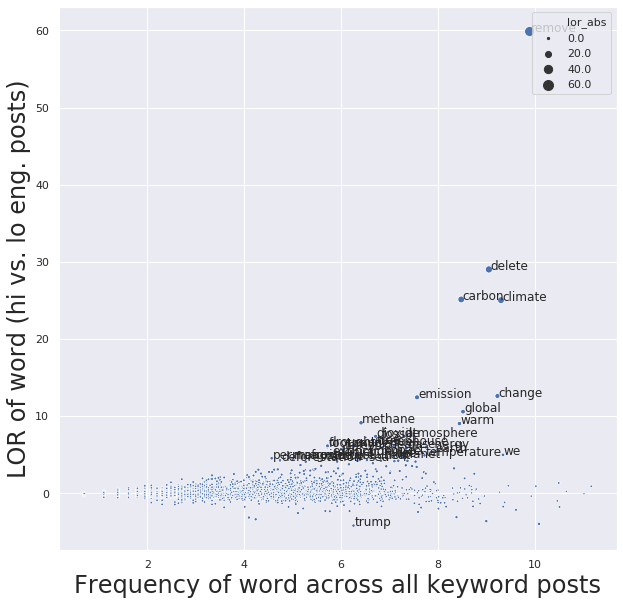

In [199]:
stance_lor_df_2 = lor_report(annotated_df,VOCAB_COUNTS_BACKGROUND_BODY,N_BACKGROUND_BODY_LEMS,
                             set(liberal_df['id']),set(conservative_df['id']),'body_lemmas',
                             'stance_lor_body_lemmas.png',
                             n_to_label=40)

In [201]:
# Most conservative post body words
stance_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[-50:]

word  lor_hi_to_lo   freq   log_freq  background_freq  \
2660          for     -1.220002  11775   9.373734           612807   
3758          out     -1.220108   2991   8.003363           193757   
2447   cloudiness     -1.224416     15   2.708050               55   
168         movie     -1.225088    106   4.663439            26136   
4087   foundation     -1.237822    109   4.691348             1482   
4496       macron     -1.238732      8   2.079442                8   
6651        never     -1.249057    701   6.552508            65128   
4634         game     -1.257027    157   5.056246            35240   
318           one     -1.261270   3147   8.054205           188988   
2351           go     -1.262407   3413   8.135347           219035   
7521     laureate     -1.270761     19   2.944439               48   
3199         club     -1.320939    119   4.779123             4176   
6064        story     -1.322643    332   5.805135            51307   
1285         them     -1.327287   1829   7.511525           136359   
6279    schneider     -1.328493     14   2.639057               37   
7027         with     -1.360466   7104   8.868413           403584   
4574      control     -1.382918    531   6.274762            14873   
6533     chairman     -1.388652     30   3.401197              231   
703       founder     -1.401297     74   4.304065              726   
6795      federal     -1.430949    158   5.062595             4382   
2735  noctilucent     -1.472845     10   2.302585               10   
7716         want     -1.473298   2017   7.609367           168125   
3518         girl     -1.473398     28   3.332205            32641   
742           guy     -1.474712    591   6.381816            71547   
1540     landfall     -1.490235     13   2.564949               22   
1558          him     -1.566312    427   6.056784            73898   
4486       friend     -1.699165    372   5.918894            79828   
4219          his     -1.733451    927   6.831954            85472   
293          they     -1.737258   6134   8.721602           287901   
486            do     -1.758218  11444   9.345221           780022   
7729          get     -1.765907   3517   8.165364           294540   
7227        tidal     -1.791878     55   4.007333              165   
5922            a     -1.800567  36590  10.507530          1852484   
5696        elite     -1.803368    136   4.912655              960   
2279     alarmism     -1.864968     36   3.583519               43   
297          your     -1.884274   2099   7.649216           210765   
1551       former     -2.005237    184   5.214936             2844   
7352           me     -2.021013   3005   8.008033           319790   
2522         have     -2.173191  14877   9.607572           836788   
2013       agenda     -2.332500    291   5.673323             1501   
24            she     -2.337033    479   6.171701           130285   
2576          her     -2.372903    319   5.765191           119105   
5809           he     -2.451126   1971   7.586296           188582   
3132     alarmist     -2.596926    165   5.105945              204   
5601           my     -3.133973   4359   8.379998           574789   
2847    oligarchy     -3.178936     60   4.094345              122   
2106      sunspot     -3.409984     69   4.234107              101   
3364          you     -3.646520   8066   8.995413           700250   
1176            i     -4.004121  23921  10.082512          2227876   
4372        trump     -4.220096    520   6.253829              770   

      log_background_freq   lor_abs  
2660            13.325805  1.220002  
3758            12.174360  1.220108  
2447             4.007333  1.224416  
168             10.171069  1.225088  
4087             7.301148  1.237822  
4496             2.079442  1.238732  
6651            11.084110  1.249057  
4634            10.469937  1.257027  
318             12.149439  1.261270  
2351            12.296987  1.262407  
7521             3.87120

In [202]:
# Most liberal post body words
stance_lor_df_2.sort_values('lor_hi_to_lo',ascending=False)[:50]

word  lor_hi_to_lo   freq  log_freq  background_freq  \
7037         remove     59.864687  19738  9.890301            27928   
317          delete     29.002656   8517  9.049819            12032   
3945         carbon     25.110055   4808  8.478036             6432   
7385        climate     25.012653  10931  9.299358            12540   
6385         change     12.584503  10147  9.224933            57299   
5416       emission     12.416911   1930  7.565275             2319   
7769         global     10.557222   4988  8.514790             7939   
1404        methane      9.113297    608  6.410175              753   
5932           warm      9.011052   4631  8.440528             7646   
4717     atmosphere      7.363089   1482  7.301148             3225   
6952        dioxide      7.357956    821  6.710523             1005   
467          fossil      7.156865    918  6.822197             1634   
995            tree      6.423647    817  6.705639             4550   
2633     greenhouse      6.319692    832  6.723832             1005   
1780           fuel      6.172109   1205  7.094235             3556   
7239        drought      6.130428    304  5.717028              404   
4289         oxygen      6.081515    512  6.238325             2150   
4602      footprint      5.974923    303  5.713733              471   
416          energy      5.957720   2321  7.749753            11861   
3175          ocean      5.921226    948  6.854355             2978   
6503            gas      5.895008   1554  7.348588             7263   
5310         forest      5.835070    424  6.049733             1293   
3367          earth      5.392551   2763  7.924072            14925   
6323         impact      5.086887    946  6.852243             6014   
643      extinction      5.042857    330  5.799093              729   
3815         reduce      4.954760    898  6.800170             4469   
392              we      4.951268  11391  9.340579           267816   
7612         denier      4.924533    364  5.897154              444   
2066    temperature      4.886514   2252  7.719574             6874   
1375           rise      4.782113   1198  7.088409             5170   
7084         planet      4.635616   1426  7.262629             8216   
4688      pollution      4.541024    539  6.289716             1073   
2277           heat      4.527532    955  6.861711             6460   
2737     permafrost      4.511029     96  4.564348               99   
2127    agriculture      4.486497    206  5.327876              506   
3228       monoxide      4.443599    148  4.997212              191   
5213         arctic      4.412224    313  5.746203              509   
5444            sea      4.279169    686  6.530878             2747   
6146  deforestation      4.235543    114  4.736198              163   
1496           melt      4.216688    560  6.327937             1748   
6972            ice      4.193660   1310  7.177782             4942   
6124    environment      4.188883    916  6.820016             5267   
1636         effect      4.175991   1584  7.367709            13666   
3617          plant      4.133692   1210  7.098376            12511   
5223      renewable      4.075180    371  5.916202              710   
6593       increase      4.075170   1871  7.534228            11117   
5400         offset      4.068853    194  5.267858              456   
2875  environmental      3.861101    776  6.654153             2145   
1792           coal      3.726942    473  6.159095              992   
4737      ecosystem      3.628573    174  5.159055              489   

      log_background_freq    lor_abs  
7037            10.237385  59.864687  
317              9.395325  29.002656  
3945             8.769041  25.110055  
7385             9.436679  25.012653  
6385            10.956038  12.584503  
5416             7.748891  12.416911  
7769             8.979543  10.557222  
1404             6.624065   9.113297  
5932             8.941938   9.011052  
471

Partitioning data into groups
Excluding non-alpha tokens. Number of tokens in 2 post groups (high, low): 4394395 843051
Excluding non-nltk words. Number of tokens in 2 post groups (high, low): 4152152 789814
Vocab size of hi, lo engagement, background posts: 18696 12266 50652
Size of joint vocab: 11069
Proportion of joint vocab in hi: 0.5920517757809157
Proportion of joint vocab in lo: 0.9024131746290559


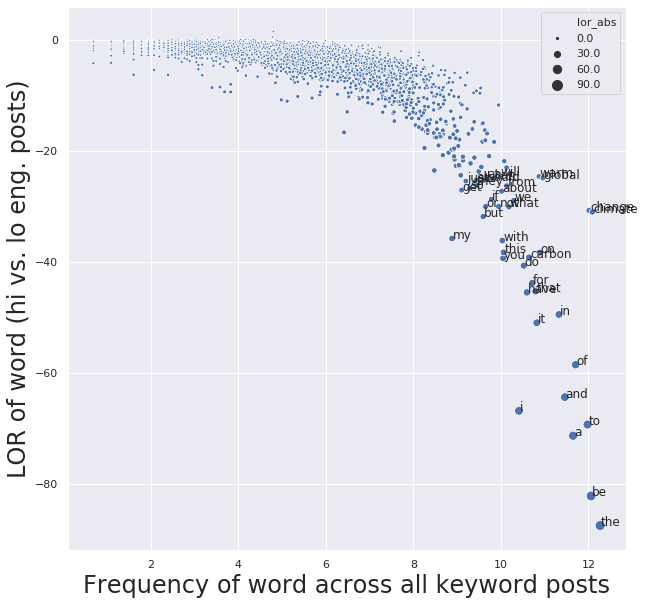

In [203]:
stance_lor_df_3 = lor_report(annotated_df,VOCAB_COUNTS_BACKGROUND_BODY+VOCAB_COUNTS_BACKGROUND_TITLE,
                             N_BACKGROUND_BODY_LEMS+N_BACKGROUND_TITLE_LEMS,
                             set(liberal_df['id']),set(conservative_df['id']),'both',
                             'stance_lor_both_lemmas.png',
                             n_to_label=40)

In [204]:
stance_lor_df_3.sort_values('lor_hi_to_lo',ascending=False)[:50]

word  lor_hi_to_lo  freq  log_freq  background_freq  \
1099            grist      1.488654   122  4.804021             1392   
6529       turbulence      0.462079   119  4.779123             2557   
3710           baobab      0.373706    35  3.555348              679   
1053          censure      0.257615    21  3.044522              356   
2573            irene      0.110923    17  2.833213              421   
3268           horner      0.097537    10  2.302585              213   
9391     adaptability      0.077950    14  2.639057              355   
3144           dengue      0.074567    64  4.158883             1918   
9393       unburnable      0.064897    17  2.833213              399   
8659         islander      0.057027    58  4.060443             1889   
5892          roundup      0.055064    77  4.343805             2487   
4009         songbird      0.040324    32  3.465736              943   
1247            getup      0.038604     6  1.791759              121   
6196          quibble      0.032389     7  1.945910              158   
10741   acceptability      0.027297     4  1.386294               60   
8961           waxman      0.015106    17  2.833213              450   
5028           bumble      0.005305    20  2.995732              641   
7750        symposium      0.000246    31  3.433987              898   
5068            basin     -0.001359   128  4.852030             4181   
5335           turney     -0.002984     3  1.098612               36   
10626      resiliency     -0.006885    30  3.401197             1020   
9661     deglaciation     -0.020332    21  3.044522              563   
5291     philanthropy     -0.025899    27  3.295837              867   
3255          crustal     -0.026888     4  1.386294               84   
7069         glossary     -0.031936     7  1.945910              203   
7471           heyday     -0.032582     4  1.386294               87   
7053             ashy     -0.035593     3  1.098612               48   
10325          possum     -0.036085    12  2.484907              397   
2548     anticipatory     -0.037961     3  1.098612               49   
5122          fishery     -0.039935   132  4.882802             4608   
5240          cowgate     -0.043256     2  0.693147                4   
1451         cropland     -0.049440    21  3.044522              678   
3787           gipper     -0.051330     3  1.098612               55   
4990      contestable     -0.058034     2  0.693147                8   
4765     chairmanship     -0.061441     6  1.791759              187   
5352           assail     -0.061949     7  1.945910              228   
306               yak     -0.066648    14  2.639057              510   
9569          grapple     -0.072093    46  3.828641             1742   
3027           sicker     -0.072792    29  3.367296             1098   
5426    correlational     -0.072863     3  1.098612               66   
8353          smarten     -0.073101     7  1.945910              238   
4590       litigation     -0.077153    69  4.234107             2468   
1128        deciduous     -0.079391    15  2.708050              566   
10134       migratory     -0.081633    81  4.394449             2779   
9780            alias     -0.087542    45  3.806662             1662   
1124            walsh     -0.089214    12  2.484907              459   
10032        feckless     -0.090734     2  0.693147               21   
1338        tinderbox     -0.090742     6  1.791759              212   
8769   disintegration     -0.092985    10  2.302585              382   
10675       episcopal     -0.094169     9  2.197225              342   

       log_background_freq   lor_abs  
1099              7.238497  1.488654  
6529              7.846590  0.462079  
3710              6.520621  0.373706  
1053              5.874931  0.257615  
2573              6.042633  0.110923  
3268              5.361292  0.097537  
9391              5.872118  0.077950  
3144              7.559038  0.07

In [205]:
stance_lor_df_3.sort_values('lor_hi_to_lo',ascending=False)[-50:]

word  lor_hi_to_lo    freq   log_freq  background_freq  \
1575       how    -21.878198   23797  10.077315          2493959   
9934     there    -22.273317   11017   9.307195          1819036   
6249       use    -22.596061    8445   9.041330          1744787   
457        one    -22.704797    7884   8.972591          1709460   
3334        go    -22.753393    8572   9.056256          1731489   
5772      make    -22.920985   14090   9.553221          2047743   
5917        by    -23.031554   25071  10.129467          2480886   
10469       me    -23.560450    4815   8.479491          1696815   
2357        an    -23.732884   13252   9.491904          2106252   
8852      like    -24.420777    8799   9.082393          1989635   
1558      will    -24.454330   21510   9.976273          2586440   
8438      warm    -24.634128   52457  10.867749          3307847   
370         at    -24.861980   15735   9.663643          2358514   
11056   global    -24.927271   57520  10.959888          3596506   
8179       can    -25.026842   18819   9.842622          2621164   
6184       all    -25.331763   12435   9.428270          2182451   
1334     would    -25.353049   14908   9.609653          2465004   
9598      just    -25.465444    9895   9.199785          2144707   
420       they    -26.014186   12458   9.430118          2161810   
3661      from    -26.294113   25084  10.129985          3000030   
10677       so    -26.779936   10791   9.286468          2364733   
11009      get    -27.096524    8984   9.103200          2357467   
2711     about    -27.297849   22371  10.015521          2923848   
3671        if    -28.751808   17768   9.785154          3070312   
566         we    -28.967703   29578  10.294786          3604157   
4483       not    -30.045431   20947   9.949751          3229923   
1731        or    -30.048859   15562   9.652587          3149766   
7509      what    -30.114401   26498  10.184825          3810198   
9071    change    -30.755651  165083  12.014204          9438868   
10522  climate    -31.043539  177784  12.088325          9925779   
1947       but    -31.863146   14705   9.595943          3344728   
7979        my    -35.803572    7225   8.885303          3788891   
9990      with    -36.182125   22766  10.033023          4531421   
6888      this    -38.313626   23477  10.063776          4811967   
166         on    -38.339222   53556  10.888483          6337829   
5590    carbon    -39.220362   41928  10.643709          6442362   
4776       you    -39.345963   23191  10.051520          5124994   
692         do    -40.708701   37146  10.522611          6233779   
3783       for    -43.831791   45115  10.716970          7189060   
2484      that    -45.314474   48630  10.791996          7499281   
3584      have    -45.517031   39907  10.594307          7247139   
6215        in    -49.499849   82890  11.325270         10345073   
1791        it    -50.993057   50033  10.820438          9146952   
2237        of    -58.550498  121370  11.706599         14470631   
3121       and    -64.375172   94946  11.461064         15222082   
1667         i    -66.850170   33320  10.413913         13528030   
3933        to    -69.311947  159350  11.978858         20209426   
8421         a    -71.330930  114593  11.649142         18729907   
1219        be    -82.178507  172840  12.060122         25337091   
8516       the    -87.511568  212677  12.267530         29218150   

       log_background_freq    lor_abs  
1575             14.729382  21.878198  
9934             14.413817  22.273317  
6249             14.372143  22.596061  
457              14.351688  22.704797  
3334             14.364492  22.753393  
5772             14.532249  22.920985  
5917             14.724126  23.031554  
10469            14.344264  23.560450  
2357             14.560421  23.732884  
8852             14.503462  24.420777  
1558             14.765793  24.454330  
8438             15.011808  24.634128  
370              14.6

Now look at neutral vs. liberal+conservative together

In [350]:
stance_lor_df_4 = lor_report(annotated_df,liberal_df.index+conservative_df.index,
           neutral_df.index,'title_lemmas',n_to_label=40)

ValueError: operands could not be broadcast together with shapes (243727,) (34874,) 

In [ ]:
stance_lor_df_4.sort_values('lor_hi_to_lo',ascending=False)[-50:]